# <font face="garamond" size="18" color="#122DAC">***The Simple Linear Regression***</font>
## <font face="garamond" size="6" color="#122DAC">*Econ 430*</font>

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import random; random.seed(10) # pre-setting seed
from scipy import stats
from scipy import optimize  # for Box-Cox calculations
from scipy.stats import norm
from matplotlib import rcParams # for ease of resizing plots
# Numpy version matters for scipy

# For model fitting
import statsmodels.api as sm
import statsmodels.stats.api as sms
import statsmodels.formula.api as smf
from fitter import Fitter # might require install, numpy version matters
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
from sklearn import metrics

# For R kernel
# Note: need working copy of R, initiate chunk with `%%R`
import rpy2.ipython
%load_ext rpy2.ipython

To install a package (e.g., `fitter` or `seaborn`), you can use `pip` or `conda`, depending on preference. To use `pip`, you can type in the command line (terminal), `pip install package`, replacing "package" with the package's name.

# <font face="garamond" size="14" color="#122DAC">1. Univariate Characterizations</font>

In a regression setting we first start by looking at a univariate characterization of the data. This entails looking at the respective statistical summaries, features, and distributions of all the variables we have. Among the popular univariate graphical tools, we will consider histograms, density plots, qqplots, and boxplots.

## 1.1 Statistical Summary

Looking at the summary statistics of our data allows to identify any potential issues we may encounter when building our regression model. For example, there may NAs, values outside the expected range, etc. Below are two examples using `pandas` and `scipy`.

First we will look at a univariate case:

In [2]:
# Generate standard normal data
df1 = pd.DataFrame({'x':random.normal(size=100)})

# A quick glance
df1.head()

x
0  1.331587
1  0.715279
2 -1.545400
3 -0.008384
4  0.621336

In [3]:
# Missing observations
df1.isnull().sum() # can also use `.any()`

x    0
dtype: int64

In [4]:
# Basic summary
print(df1.describe())

# And a bit more
df1_skew = stats.skew(df1["x"])
df1_kurt = stats.kurtosis(df1["x"])
print(f'skew\t {df1_skew:.5}')
print(f'kurtosis {df1_kurt:.6}')

                x
count  100.000000
mean     0.079417
std      0.971911
min     -2.131712
25%     -0.483904
50%      0.094368
75%      0.672214
max      2.467651
skew	 0.013641
kurtosis 0.124532


Then moving to a full datacube...

In [5]:
# Import data file
prestige = pd.read_csv('data/prestige.csv', index_col=0)

# A quick glance
prestige.head()

education  income  women  prestige  census  type
gov.administrators       13.11   12351  11.16      68.8    1113  prof
general.managers         12.26   25879   4.02      69.1    1130  prof
accountants              12.77    9271  15.70      63.4    1171  prof
purchasing.officers      11.42    8865   9.11      56.8    1175  prof
chemists                 14.62    8403  11.68      73.5    2111  prof

In [6]:
# Missing observations
prestige.isnull().sum() # can also use `.any()`

education    0
income       0
women        0
prestige     0
census       0
type         4
dtype: int64

In [7]:
# Basic summary
prestige_desc = prestige.describe()

# Adding skewness and kurtosis
prestige_desc.loc['skew'] = prestige.apply(lambda x: stats.skew(x))
prestige_desc.loc['kurtosis'] = prestige.apply(lambda x: stats.kurtosis(x))

prestige_desc

education        income       women    prestige       census
count     102.000000    102.000000  102.000000  102.000000   102.000000
mean       10.738039   6797.901961   28.979020   46.833333  5401.774510
std         2.728444   4245.922227   31.724931   17.204486  2644.993215
min         6.380000    611.000000    0.000000   14.800000  1113.000000
25%         8.445000   4106.000000    3.592500   35.225000  3120.500000
50%        10.540000   5930.500000   13.600000   43.600000  5135.000000
75%        12.647500   8187.250000   52.202500   59.275000  8312.500000
max        15.970000  25879.000000   97.510000   87.200000  9517.000000
skew        0.329586      2.160717    0.912158    0.333595     0.113271
kurtosis   -0.989170      6.472571   -0.629538   -0.748652    -1.460248

## 1.2 Histograms

Histograms should be one our first analysis tool since they can help us learn about each variable's properties. 

Things to look for:

- ***Outliers:** This can influence the regression fit in many ways* 
- ***Shape:** Is the distribution symmetric, skewed, etc?*
- ***Range:** Is the range of values very large? For example several orders of magnitude?*
- ***Density** of observations and/or clustering features. Are the data all clustered in certain regions? In high density regions your regression fit may be robust but then become unstable in less dense ones.*

The near optimal number of bins to use based on the number of observations n is given by:
$$k= 1 + \log_{2}(n)$$

However, more sample-specific formulas exist such as Freedman's and Diaconis (FD)' suggested:
$$\frac{n^{1/3}(\max-\min)}{2(Q_3 - Q_1)}$$

For example, we can compare the two methods for 2 different data sets:


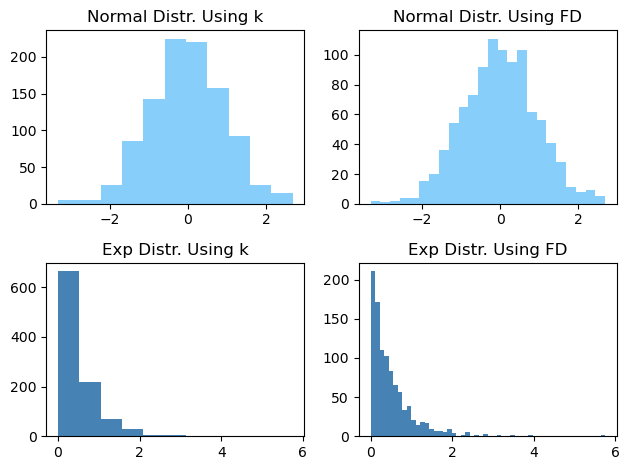

In [8]:
# Comparing histograms using k vs FD:

n = 1000
x1 = random.normal(size=n)
x2 = random.exponential(0.5, size=n)
# Calculating bins
k = int(np.ceil(1 + np.log2(n)))
fd_x1 = int(0.5 * (n**(1/3) * (max(x1) - min(x1))) / (np.quantile(x1, 0.75) - np.quantile(x1, 0.25)))
fd_x2 = int(0.5 * (n**(1/3) * (max(x2) - min(x2))) / (np.quantile(x2, 0.75) - np.quantile(x2, 0.25)))

fig1, ax1 = plt.subplots(2, 2)
ax1[0,0].hist(x1, bins=k, color='lightskyblue')
ax1[0,0].set_title('Normal Distr. Using k')
ax1[0,1].hist(x1, bins=fd_x1, color='lightskyblue')
ax1[0,1].set_title('Normal Distr. Using FD')
ax1[1,0].hist(x2, bins=k, color='steelblue')
ax1[1,0].set_title('Exp Distr. Using k')
ax1[1,1].hist(x2, bins=fd_x2, color='steelblue')
ax1[1,1].set_title('Exp Distr. Using FD')
plt.tight_layout()

## 1.3 Density Estimation
Histograms are very informative but being able to visualize the density plot, along with the histogram and 1D scatterplot (rug-plot) can be more informative. A common kernel-density (nonparametric) estimate used is given by:

$$\widehat{p}(x) = \frac{1}{nh} \sum_{i=1}^{n}K \left( \frac{x-x_i}{h}\right)$$

where $K$ is kernel function (e.g., Normal distribution), $h$ is the bandwidth (amount of smoothness), and $n$ the number of observations.

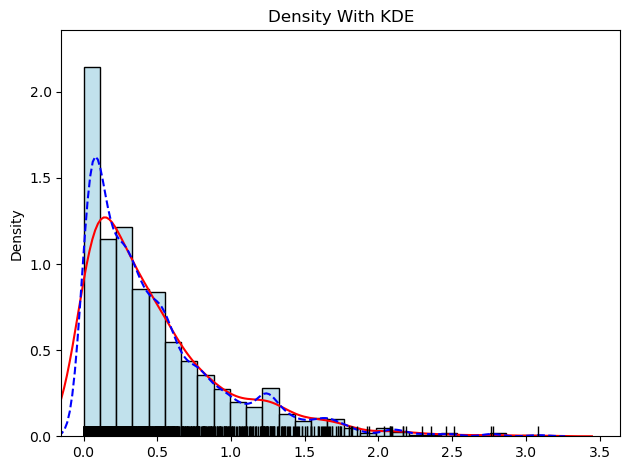

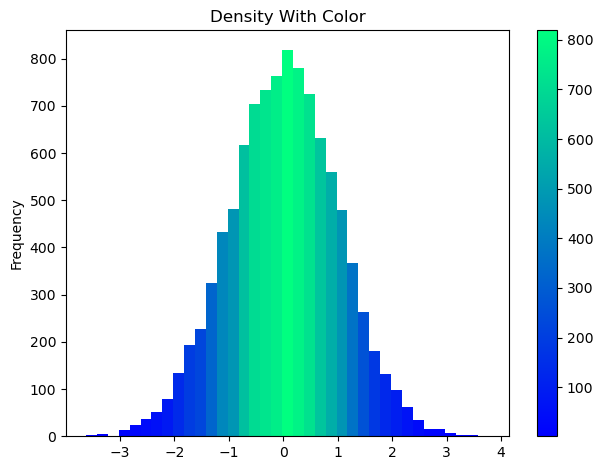

In [9]:
## Using Kernel Density Estimation

# Generate data
x3 = random.exponential(0.5, size=1000)

# Plotting
sns.histplot(x3, kde=False, stat='density', color='lightblue')
sns.kdeplot(x3, color='red')
sns.kdeplot(x3, bw_adjust=0.5, color='blue', linestyle='--') # less smooth
sns.rugplot(x3, color='black') # add rug plot
plt.xlim((-0.15, None))
plt.title('Density With KDE')
plt.tight_layout()
plt.show()


## Using color

# Generate data
x4 = random.normal(size=10000)

# Histogram
n, bins, patches = plt.hist(x4, bins=np.arange(min(x4), max(x4)+0.2, 0.2)) # bin width = 0.2

# Create colormap
max_height = max(n)
for rect, count in zip(patches, n):
    color = plt.cm.winter(count / max_height)
    rect.set_facecolor(color)

# Add colorbar
cbar = plt.cm.ScalarMappable(cmap='winter')
cbar.set_array(n)
plt.colorbar(cbar, ax=plt.gca())

# Labels and title
plt.ylabel('Frequency')
plt.title('Density With Color')
plt.tight_layout()


## 1.4 Quantile Plots

These plots are very useful for comparing the distribution of a variable to a theoretical reference distribution. By default the Normal distribution is used in the function `qqplot` from `statsmodels` (Quantile-Quantile) but we can provide any other distribution.

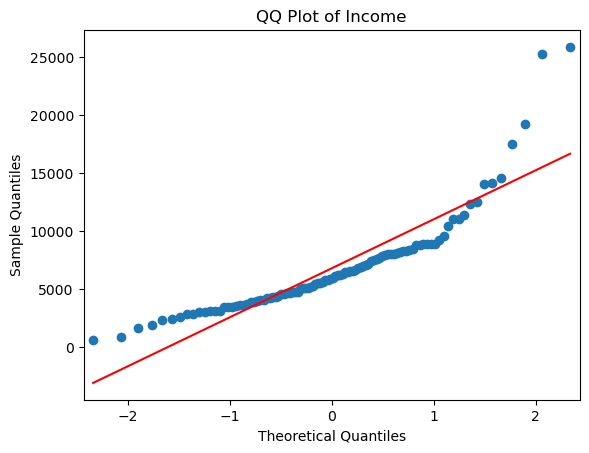

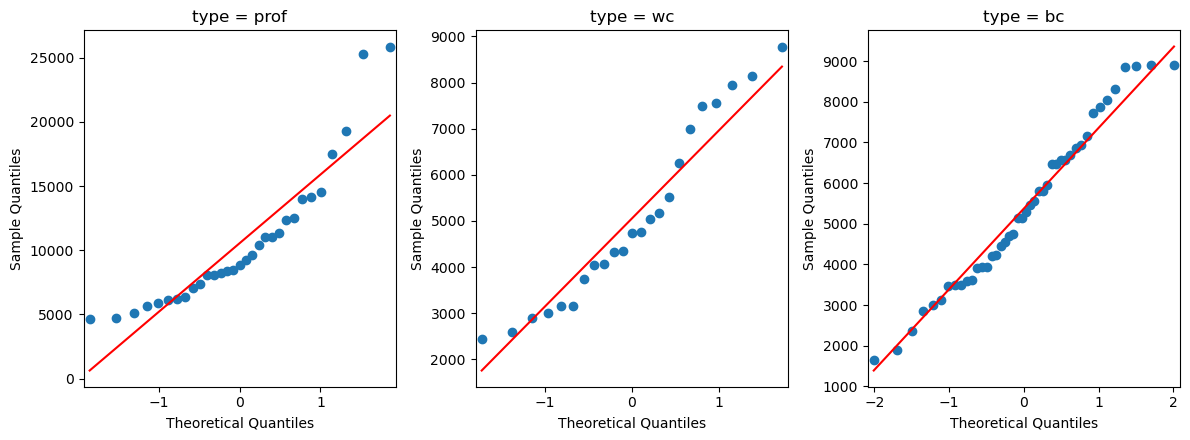

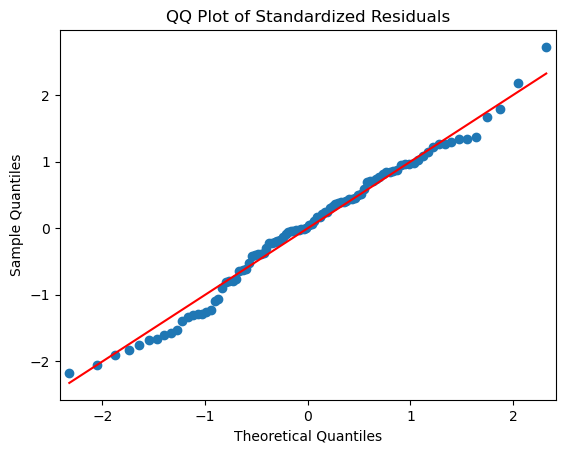

In [10]:
# Using 'prestige' data set from earlier

# Just on income
sm.qqplot(prestige['income'], line='s') 
plt.title('QQ Plot of Income')
plt.show()

# By type: Professional (prof), WHite Collar (wc), Blue Collar (bc)
fig2, ax2 = plt.subplots(1, 3, figsize=(4*3, 1.5*3))
sm.qqplot(prestige['income'][prestige['type'] == 'prof'], line='s', ax=ax2[0])
ax2[0].set_title('type = prof')
sm.qqplot(prestige['income'][prestige['type'] == 'wc'], line='s', ax=ax2[1])
ax2[1].set_title('type = wc')
sm.qqplot(prestige['income'][prestige['type'] == 'bc'], line='s', ax=ax2[2])
ax2[2].set_title('type = bc')
plt.tight_layout()

# Of OLS residuals
prestige_ols_fit = smf.ols('prestige ~ income + education + type', data=prestige).fit()
prestige_ols_influence = prestige_ols_fit.get_influence()
prestige_ols_std_resid = prestige_ols_influence.resid_studentized_internal # standardized residual
sm.qqplot(prestige_ols_std_resid, line='s') 
plt.title('QQ Plot of Standardized Residuals')
plt.show()

## 1.5 Boxplots

Boxplots allow us know more quantitative aspects of a variables distribution such as the min, max, Q1, Q3, IQR, and median. Another helpful property is that they are very convenient when comparing many distributions simultaneously and/or conditioning on other variables.

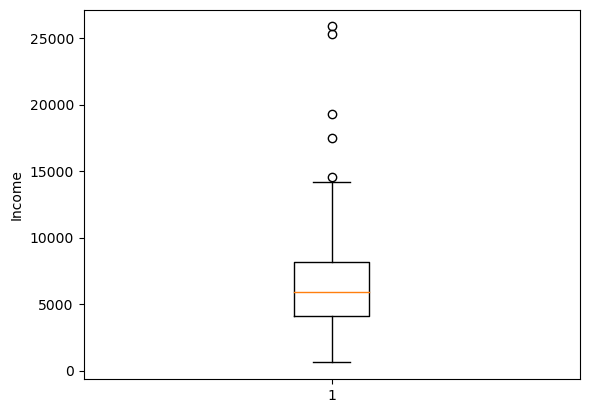

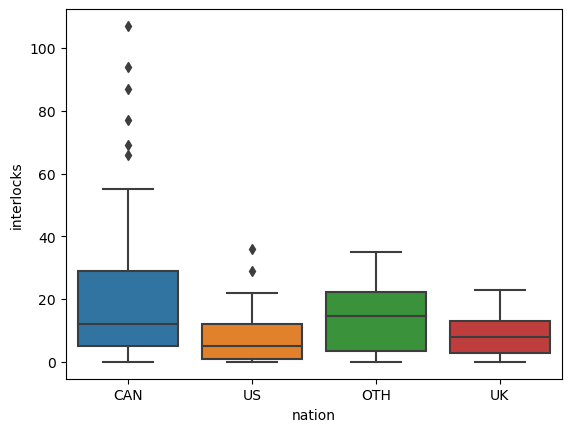

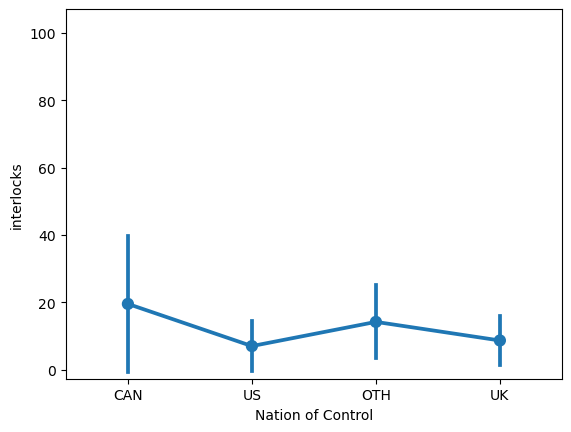

In [11]:
# Basic boxplot
plt.boxplot(prestige['income'])
plt.ylabel('Income')
plt.show()

# Import data file
ornstein = pd.read_csv('data/ornstein.csv')
# Note: 'interlocks' = number of interlocking director and executive positions shared with other major firms

# Parallel boxplots
sns.boxplot(data=ornstein, x='nation', y='interlocks')
plt.show()

# Plotting means and standard deviations
sns.pointplot(data=ornstein, x='nation', y='interlocks', errorbar='sd')
plt.ylim(top=np.max(ornstein['interlocks']))
plt.xlabel('Nation of Control')
plt.show()

## 1.6 Cullen-Frey Graph

The Cullen-Frey plot shows you different distribution fits based on some of the well known distributions. We'll first look at the empirical density and CDF, then the Cullen-Frey plot using an R kernel. After, we will compare implementation in R to implementation in Python.

In Python, the `fitter` library works by attempting to fit all 80 distributions using the `Fitter` class. During fitting, it will generate an output detailing which distributions were fit and which were unable to be fit due to errors. Then the `summary()` method generates the fitted distributions, showing the best performing distributions which minimized the mean squared error.

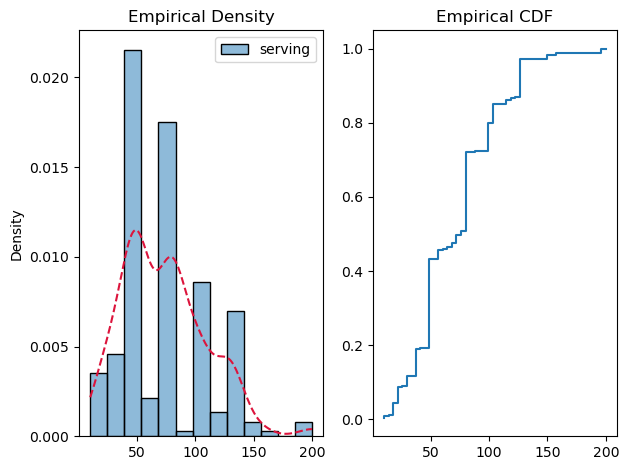

In [12]:
# Import data file
groundbeef = pd.read_csv('data/groundbeef.csv')

# create empricial CDF
groundbeef_ecdf = sm.distributions.ECDF(groundbeef['serving']) # fit distribution
groundbeef_range = np.linspace(min(groundbeef['serving']), max(groundbeef['serving'])) # grid of values
groundbeef_cdf = groundbeef_ecdf(groundbeef_range) # apply distribution

# First we look at empirical distributions
fig3, ax3 = plt.subplots(1, 2)
sns.histplot(groundbeef, stat='density', kde=True, ax=ax3[0])
ax3[0].lines[0].set_color('crimson')
ax3[0].lines[0].set_linestyle('--')
ax3[0].set_title('Empirical Density')
plt.step(groundbeef_range, groundbeef_cdf)
ax3[1].set_title('Empirical CDF')
plt.tight_layout()

summary statistics
------
min:  10   max:  200 
median:  79 
mean:  73.64567 
estimated sd:  35.88487 
estimated skewness:  0.7352745 
estimated kurtosis:  3.551384 


Loading required package: MASS
Loading required package: survival


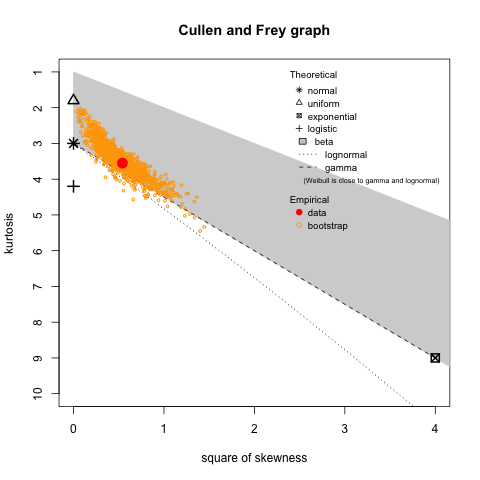

In [13]:
%%R
set.seed(10) # for bootstrap
library("fitdistrplus")
data("groundbeef")

# Cullen-Frey Graph
descdist(groundbeef$serving, boot = 1000) 

In [14]:
%%R
# Example: fitted Weibull distribution
fw <- fitdist(groundbeef$serving, "weibull")
summary(fw)

Fitting of the distribution ' weibull ' by maximum likelihood 
Parameters : 
       estimate Std. Error
shape  2.185885  0.1045756
scale 83.347679  2.5268643
Loglikelihood:  -1255.225   AIC:  2514.449   BIC:  2521.524 
Correlation matrix:
          shape     scale
shape 1.0000000 0.3218211
scale 0.3218211 1.0000000



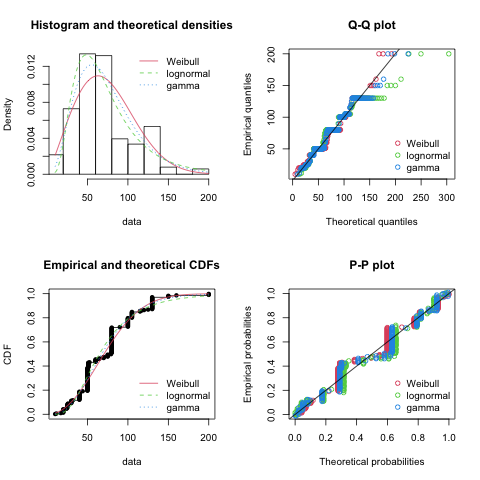

In [15]:
%%R
fg <- fitdist(groundbeef$serving, "gamma") # fitted gamma distribution
fln <- fitdist(groundbeef$serving, "lnorm") # fitted log-normal distribution

# Plotting
par(mfrow = c(2, 2))
plot.legend <- c("Weibull", "lognormal", "gamma")
denscomp(list(fw, fln, fg), legendtext = plot.legend)
qqcomp(list(fw, fln, fg), legendtext = plot.legend)
cdfcomp(list(fw, fln, fg), legendtext = plot.legend)
ppcomp(list(fw, fln, fg), legendtext = plot.legend)

SKIPPED _fit distribution (taking more than 30 seconds)
/Users/randallr.rojas/anaconda3/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:3759: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  intgrl = integrate.quad(llc, x0, x1,
/Users/randallr.rojas/anaconda3/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:3759: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intgrl = integrate.quad(llc, x0, x1,
/Users/randallr.rojas/anaconda3/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:3754: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  intgrl = (integrate.quad(llc, x0, mean,
SKIPPED kstwo distribution (taking more than 30 seconds)
SKIPPED rv_continuous distribution (taking 

sumsquare_error          aic          bic  kl_div  ks_statistic  \
dgamma             0.032315  1258.198495  1268.810498     inf      0.152785   
dweibull           0.032551  1255.353389  1265.965392     inf      0.138678   
loglaplace         0.032902  1143.681261  1154.293263     inf      0.247941   
skewnorm           0.032908  1164.414323  1175.026326     inf      0.123703   
johnsonsb          0.032914  1163.777875  1177.927212     inf      0.126131   

               ks_pvalue  
dgamma      1.213249e-05  
dweibull    1.007317e-04  
loglaplace  3.061368e-14  
skewnorm    7.592625e-04  
johnsonsb   5.559559e-04

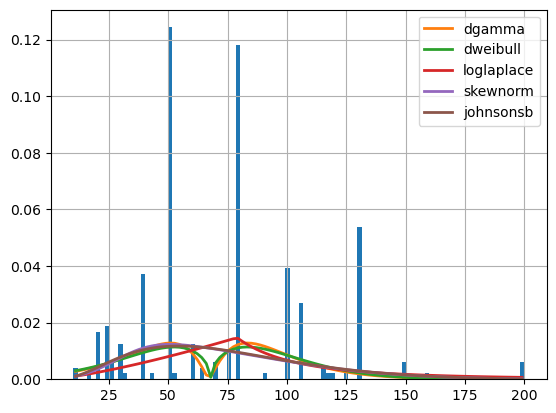

In [16]:
# Comparing to Python

# Fit various distributions
groundbeef_fit = Fitter(groundbeef['serving'])
groundbeef_fit.fit()
# Note: fitting may take a while since, by default, all distributions are tried
# You can manually provide a smaller set of distributions

groundbeef_fit.summary()

# <font face="garamond" size="14" color="#122DAC">2. Bivariate Characterizations</font>

Once you have the univariate description of the variables, we can then examine the pairwise associations via e.g., scatterplots.

## 2.1 Scatterplots

/Users/randallr.rojas/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/bg/h1rtgc4n1x18f05g47x31ylr0000gn/T/ipykernel_46705/1586789308.py:5: UserWarning: The figure layout has changed to tight
  plt.tight_layout()
/Users/randallr.rojas/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


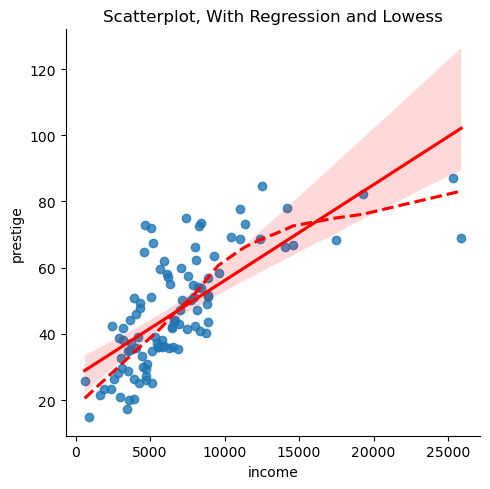

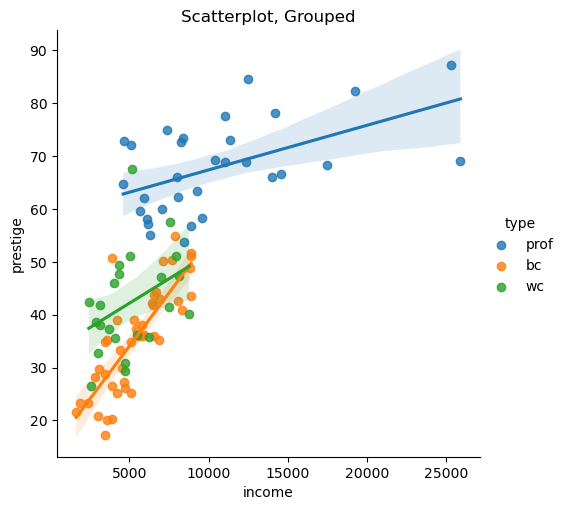

In [17]:
# Scatterplot with regression line and Lowess (locally weighted) smoother
sns.lmplot(prestige, x='income', y='prestige', line_kws={'color':'red'})
sns.regplot(prestige, x='income', y='prestige', color='red', lowess=True, scatter=False, line_kws={'linestyle':'--'})
plt.title('Scatterplot, With Regression and Lowess')
plt.tight_layout()

# Scatterplot grouped by type
sns.lmplot(prestige, x='income', y='prestige', hue='type')
plt.title('Scatterplot, Grouped')
plt.show()

/Users/randallr.rojas/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)
/var/folders/bg/h1rtgc4n1x18f05g47x31ylr0000gn/T/ipykernel_46705/3003099190.py:3: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


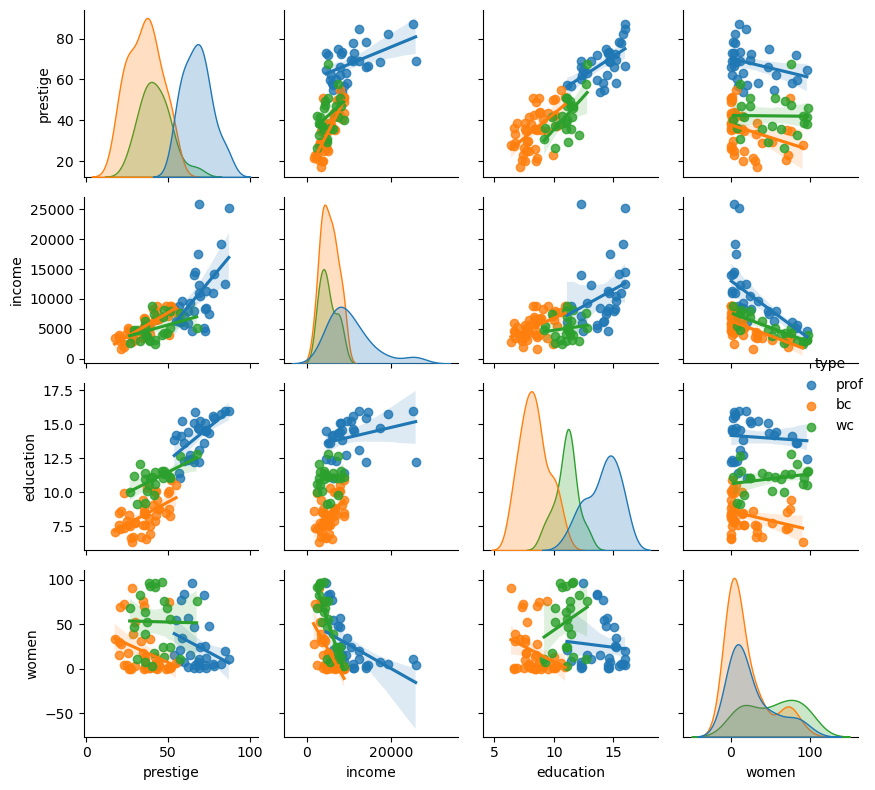

In [18]:
# Scatterplot matrix
sns.pairplot(prestige[['prestige', 'income', 'education', 'women', 'type']], hue='type', kind='reg', height=2)
plt.tight_layout()

## 2.2 Jittering Scatterplots

Jittering the data (adding noise) helps separate overplotted observations.

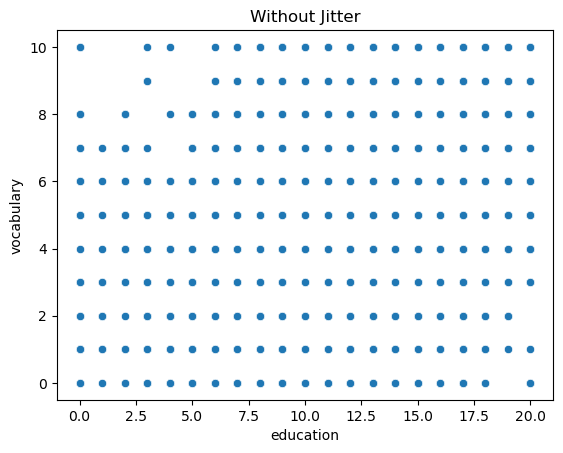

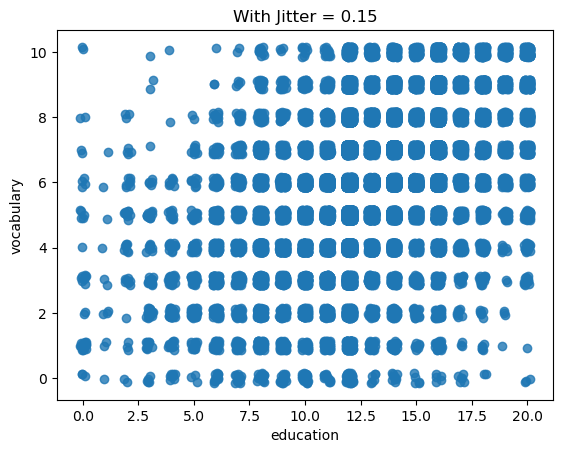

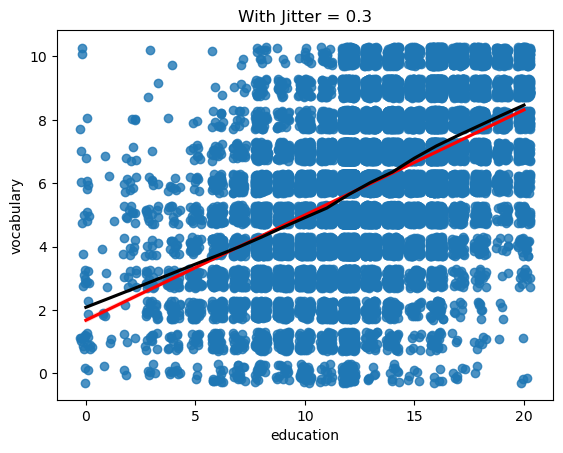

In [19]:
# Import data
vocab = pd.read_csv('data/vocab.csv', index_col=0)

# Without jitter
sns.scatterplot(x=vocab['education'], y=vocab['vocabulary'])
plt.title('Without Jitter')
plt.show()

# With jitter = 0.15
sns.regplot(vocab, x='education', y='vocabulary', x_jitter=0.15, y_jitter=0.15, fit_reg=False, seed=10)
plt.title('With Jitter = 0.15')
plt.show()

# With jitter = 0.3
# Lowess in black, regression line in red
sns.regplot(vocab, x='education', y='vocabulary', x_jitter=0.3, y_jitter=0.3, fit_reg=False, seed=10)
sns.regplot(vocab, x='education', y='vocabulary', fit_reg=True, scatter=False, color='red')
sns.regplot(vocab, x='education', y='vocabulary', lowess=True, scatter=False, color='black')
plt.title('With Jitter = 0.3')
plt.show()

# <font face="garamond" size="14" color="#122DAC">3. The Method of Least Squares for the Simple Linear Regression</font>

Economic theory suggests many relationships between economic variables. A regression model is helpful in questions such as the following: *if one variable changes in a certain way, by how much will another variable change? For example, by how much do you expect hourly wages to increase with an additional year of education?*

* The regression model is based on assumptions about the conditional pdf of $y$ (e.g., hourly wages) given $x$ (e.g., years of education).
    - The continuous random variable $y$ has a probability density function (pdf).
    - The pdf is a conditional probability density function because it is "conditional" upon an $x$*
* For example, households with an income of \$1000 per week would have various food expenditure per person for a variety of reasons.
* The pdf $f(y)$ describes how expenditures are distributed over the population.
* This is a conditional pdf because it is "conditional" upon household income.
* The conditional mean, or expected value, of $y$ is $E\left[ y \vert x=\$1000\right]  =\mu_{y\vert x}$ and is our population's mean weekly food expenditure per person.
* The conditional variance of $y$ is $\mathrm{Var}\left[y \vert x=\$1000\right]  =\sigma^{2}$ which measures the dispersion of household expenditures $y$ about their mean.
* The parameters $\mu_{y \vert x}$ and $\sigma^{2}$, if they were known, would give us some valuable information about the population we are considering.
* In order to investigate the relationship between expenditure and income we must build an economic model and then a corresponding econometric model that forms the basis for a quantitative or empirical economic analysis.
* This econometric model is also called a regression model.

Some terminology...
| $y$   | $x$   |
|:---:|:---:|
|Dependent variable  |Independent variable    |
|   Explained variable  |   Explanatory variable    |
|   Response variable  |   Control variable    |
|   Predicted variable  |   Predictor variable    |
|   Regressand  |   Regressor    |

## 3.1 An Econometric Model

The *Econometric Model* is the motivation, e.g., it could be a supply equation, therefore, it comes from economic theory. The parameters of the model are also known as the population parameters. For example, let's examine the relationship between weekly food expenditure and weekly household income.

* A household spends \$80 plus 10 cents of each dollar of income received on food.
* Algebraically the rule is $y=80+0.10x$ where $y$ = weekly household food expenditure (\$) and $x$ = weekly household income (\$).
* In reality, many factors may affect household expenditure on food.
* Let $e$ (error term) = everything else affecting food other than income.
* $y=\beta_{1}+\beta_{2}x+e$. This equation is the simple regression model.
* A simple linear regression analysis examines the relationship between a $y$-variable and one $x$-variable.

<img src="images/L1_fig1.jpg" alt="(a) Probability distribution $f(y|x=1000)$ of food expenditure $y$ given income $x=\$1000$. (b) Probability distribution $f(y|x=2000)$ of food expenditure $y$ given income $x=\$2000$." width="750">

#### *Code Example*

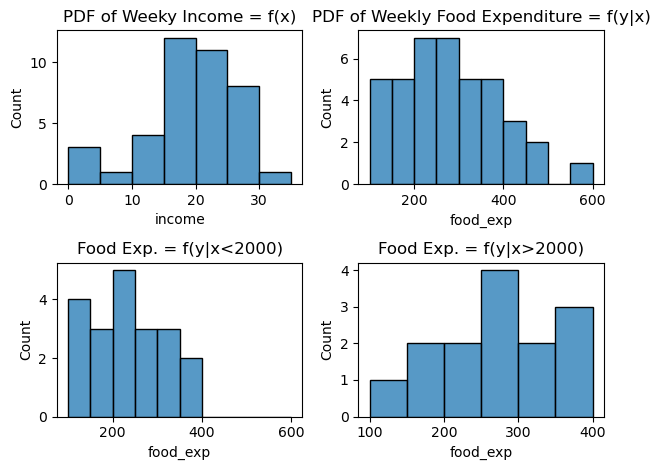

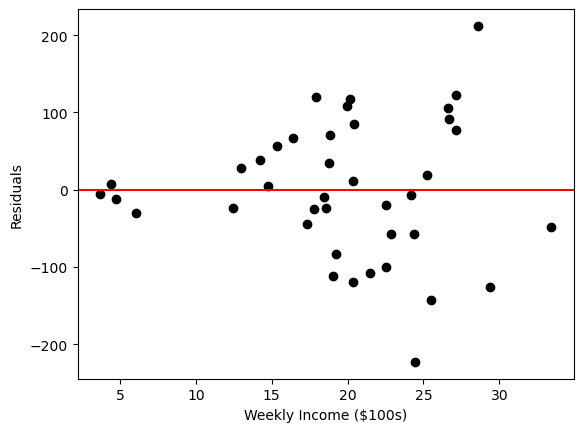

In [20]:
# Import data
food = pd.read_csv('data/food.csv')

# Histograms
fig4, ax4 = plt.subplots(2, 2)
sns.histplot(food['income'], bins=range(0,40,5), ax=ax4[0,0]) # predictor
ax4[0,0].set_title('PDF of Weeky Income = f(x)')
sns.histplot(food['food_exp'], bins=range(100,650,50), ax=ax4[0,1]) # outcome
ax4[0,1].set_title('PDF of Weekly Food Expenditure = f(y|x)')
sns.histplot(food['food_exp'][food['income'] <= 20], bins=range(100,650,50), ax=ax4[1,0]) # f(y|x<2000)
ax4[1,0].set_title('Food Exp. = f(y|x<2000)')
sns.histplot(food['food_exp'][food['income'] > 20], bins=range(100,450,50), ax=ax4[1,1]) # f(y|x>2000)
ax4[1,1].set_title('Food Exp. = f(y|x>2000)')
plt.tight_layout()
plt.show()

# OLS model
food_ols = smf.ols('food_exp ~ income', data=food).fit()
plt.scatter(x=food['income'], y=food_ols.resid, color='black')
plt.axhline(y=0, color='red')
plt.ylabel('Residuals')
plt.xlabel('Weekly Income ($100s)')
plt.show()
# Note: from the residual plot, we can see non-constant variance

### 3.1.1 Data Generating Process

The Simple Linear Regression (SLR) model is given by:
$$
y_i=\beta_0+\beta_1 x_i+e_i
$$

In most software packages (Python, R, etc.) the default null hypothesis tested is $H_0: \beta_k=0$ against the alternative $H_1:\beta_k \not=0,\ k=0,1$. Therefore, if the respective estimated p-value is small ($p$-value $< \alpha$), we reject $H_0$ and conclude that the respective parameter is statistically significantly different from 0.

The Simple Linear Regression (SR) assumptions of the model are that:
1. *Linearity:* The value of $y$, for each value of $x$, is $y= \beta_0 + \beta_1x + e$
2. $E[e_i | x_i] = 0$ which is the same as $E[y]= \beta_0 + \beta_1 x$
3. *Homoskedasticity:* $\mathrm{Var}[e_i| x_i] = \mathrm{Var}[y] =\sigma^2$ (constant variance condition, i.e., the errors are *homoskedastic*)
4. $\mathrm{cov}(y_i, y_j) = \mathrm{cov}(e_i, e_j| x) = 0$ (even better if the errors are independent which is a stronger condition)
5. *Rank Condition:* $x$ is not random and takes on at least two different values
6. *Normality (Optional)*: The errors are normally distributed, i.e., $e_i|x_i \sim N(0,\sigma^2)$

Note: Since the data $\{(x_1,y_1),\ldots, (x_n,y_n)\}$ is a random sample, both $x$'s and $y$'s are independent and identically distributed (*iid*).

### 3.1.2 The Random Error and Strict Exogeneity


* The second assumption of the simple regression model concerns the "everything else" term $e$.
* Unlike food expenditure and income, the random error term is not observable; it is unobservable.
* The $x$-variable, income, cannot be used to predict the value of $e$.
* $E\left[ e_{i} \vert x_{i}\right]  =0$ has two implications:
    + $E\left[  e_{i}\right]  = 0$
    + $\mathrm{cov}\left(  e_{i},x_{i}\right)  =0$

To better understand the *error* term we can think of decomposing the observation $y$ into 2 components: 
1. $E[y|x] = \beta_1 + \beta_2 x$, which represents the systematic component of $y$, and
2. $e = y -E[y|x] = y - \beta_1 - \beta_2 x$, which represents the random component and thus, encapsulates everything else that contributes to the variations in $y$. Therefore,
 
$$
\underbrace{y}_{\text{Data}}\ =\ \underbrace{\beta_1+\beta_2 x}_{\text{Model}}\ +\ \underbrace{e}_{\text{Uncertainty}}.
$$

#### *Code Example*

In [21]:
# Test covariance assumption
food_ols = smf.ols('food_exp ~ income', data=food).fit()
food_resid = food_ols.resid # residuals
print(np.cov(food['income'], food_resid)) # off-diagonals (cov) close enough to 0

# Test E[e] = 0
np.mean(food_resid) # close enough to 0

[[ 4.68919897e+01 -5.94110191e-14]
 [-5.94110191e-14  7.80782502e+03]]


-2.0250467969162856e-14

### 3.1.3 The Regression Function

The conditional expectation $E\left[y_{i}\vert x_{i}\right]  =\beta_{1}+\beta_{2}x_{i}$ is called the regression function.

This also says, given a change in $x$ $(\Delta x)$ the resulting change in $E\left[y_{i} \vert x_{i}\right]$ is $(\beta_{2}\times\Delta x)$ holding all else constant.

We can't say that a change in $x$ leads to, or causes, a change in the expected (population average) value of $y$ given $x_{i}$, $E\left[y_{i}\vert x_{i}\right]$ 


<img src="images/L1_fig2.jpg" alt="The Economic Model: a linear relationship between average per person food expenditure and income." width="575">

* The fitted regression line is $$\widehat{y_i}=b_1 + b_2 x_i$$ and the residual is $$\widehat{e_i}=y_i-\widehat{y_i} = y_i - b_1 - b_2 x_i$$
* The $b$'s are chosen to minimize $$ \sum^n_{i=1}\hat e_i^2 = \sum^N_{i=1}(y_i-\hat{y_i})^2 = \sum^N_{i=1}(y_i - b_1 - b_2 x_i)^2$$
* The First Order Condition (FOC) of minimization is
\begin{align*}
0 &= \sum^N_{i=1}(y_i - b_1 - b_2 x_i) = \sum^N_{i=1}\widehat{e_i} \\
0 &= \sum^N_{i=1}x_i(y_i - b_1 - b_2 x_i) = \sum^N_{i=1}x_i\widehat{e_i}
\end{align*}
* We will call the estimators given by
\begin{align*}
b_2 &= \frac{\sum(x_i-\bar x)(y_i-\bar y)}{\sum(x_i - \bar x)^2} \\
b_1 &= \bar y - b_2 \bar x
\end{align*}
the ordinary least squares estimators. "Ordinary least squares" is abbreviated as OLS.

* It can be shown that
\begin{gather*}
b_2=\sum^N_{i=1}w_iy_i, \phantom{-}\text{where}\\
w_i=\frac{(x_i-\bar x)}{\sum(x_i-\bar x)}
\end{gather*}
* It could also be written as $$b_2 = \beta_2 + \sum^N_{i=1}w_ie_i$$ based on which we obtain $$E[b_2]=\beta_2,$$ i.e., it is unbiased.
* It can further be shown that
\begin{align*}
\mathrm{Var}(b_2) &= \frac{\sigma^2}{\sum(x_i-\bar x)^2} \\
\mathrm{Var}(b_1) &= \sigma^2\frac{\sum x_i^2}{N\sum(x_i-\bar x)^2} \\
\mathrm{cov}(b_1, b_2) &= -\sigma^2\frac{\bar x}{N\sum(x_i-\bar x)^2}
\end{align*}

* Note that...
    1. The larger the variance term, the greater the uncertainty there is in the statistical model, and the larger the variances and covariance of the least squares estimators.
    2. The larger the sum of squares $\sum\left(x_{i}-\overline{x}\right)^{2}$, the smaller the variances of the least squares estimators and the more precisely we can estimate the unknown parameters.
    3. The larger the sample size $N$, the smaller the variances and covariance of the least squares estimators.

### 3.1.4 Random Error Variation

Ideally, the conditional variance of the random error is constant, $\mathrm{Var}\left[e_{i}\vert x_{i}\right] =\sigma^{2}$. This is the homoskedasticity assumption.

Assuming the population relationship $y_{i}=\beta_{1}+\beta_{2} x_{i}+e_{i}$ the conditional variance of the dependent variable is
$$
\mathrm{Var}\left[y_{i}\vert x_{i}\right] = \mathrm{Var}\left[ \beta_{1}+\beta_{2}x_{i}+e_{i} \vert
x_{i}\right]  = \mathrm{Var}\left[ e_{i} \vert x_{i}\right]  = \sigma^{2}
$$

If this assumption is violated, and $\mathrm{Var}\left[e_{i} \vert x_{i}\right]$ may depend on $x_{i}$, then the random errors are said to be *heteroskedastic*.

#### *Code Example*

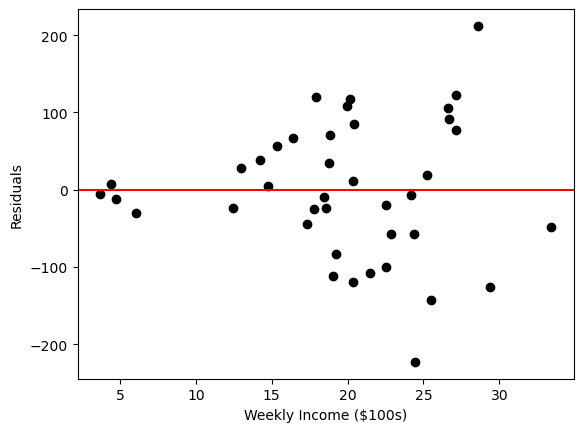

In [22]:
# Revisiting the same model
food_ols = smf.ols('food_exp ~ income', data=food).fit()
# A plot of the estimate of the errors, i.e., the residuals, shows that they are heteroskedastic.
plt.scatter(x=food['income'], y=food_ols.resid, color='black')
plt.axhline(y=0, color='red')
plt.ylabel('Residuals')
plt.xlabel('Weekly Income ($100s)')
plt.show()

### 3.1.5 Variation in $x$

In a regression analysis, one of the objectives is to estimate $\beta_{2}=\frac{\Delta E\left[y_{i} \vert x_{i}\right]}{\Delta x}$.

* If we are to hope that a sample of data can be used to estimate the
effects of changes in $x$, then we must observe some different values of the
explanatory variable $x$ in the sample.
* The minimum number of $x$-values in a sample of data that will allow us
to proceed is two.
* $\beta_2$ in this case represents the slope, which tells us by how much does the dependent variable $y$ change if the independent variable $x$ is increased by 1 unit.

<img src="images/L1_fig3.jpg" alt="Conditional PDFs for food expenditure, at two different levels of income." width="500">

### 3.1.6 Error Normality

The normality of the residuals can be helpful but is not required. We can perform a Jarque-Bera (JB) test on the residuals to determine if they are normally distributed. The JB statistic is given by:
$$
JB = \frac{N}{6}\left(S^2 + \frac{(K-3)^2}{4}\right),$$
 where $K$ = kurtosis and $S$ = skewness. For a normal distribution $K=3$ and $S=0$. We can show that $JB \sim \chi_{\nu=2}^{2}$, where the null hypothesis is $H_0: JB = 0$.

#### *Code Example*

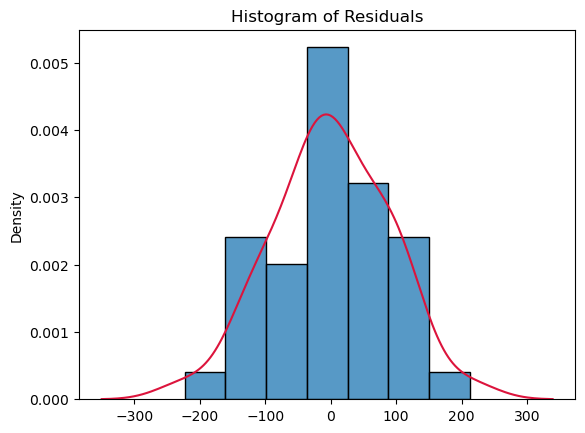

JB:	 0.06334
p-val:	 0.9688
skew:	 -0.09732
kurt:	 2.989


In [23]:
# Revisiting the same model
food_ols = smf.ols('food_exp ~ income', data=food).fit()
# A plot of the estimate of the errors, i.e., the residuals, shows that they are heteroskedastic.
sns.histplot(x=food_ols.resid, stat='density')
sns.kdeplot(x=food_ols.resid, color='crimson')
plt.title('Histogram of Residuals')
plt.show()

# Performing Jarque-Bera test
## H0: normality
food_jb_test = sms.stattools.jarque_bera(food_ols.resid)
for p,q in zip(['JB', 'p-val', 'skew', 'kurt'], food_jb_test): print(f'{p}:\t {q:.4}')
## p = 0.969: fail to reject H0

* When samples are small, it is advantageous for statistical inferences that the random errors, and dependent variable $y$, given each $x$-value, are normally distributed.
* The Central Limit Theorem says roughly that collections of many random factors tend toward having a normal distribution.

### 3.1.7 Error Correlation

* It is possible that there are correlations between the random error terms.
* With cross-sectional data, data collected at one point in time, there may be a lack of statistical independence between random errors for individuals who are spatially connected.
* Within a larger sample of data, there may be clusters of observations with correlated errors because of the spatial component.
* The starting point in regression analysis is to assume that there is no error correlation.

## 3.2 Estimating the Regression Parameters

* We can use the sample data values of $y_{i}$ and $x_{i}$ from the `food` data set, to estimate the unknown regression parameters $\beta_{1}$ and $\beta_{2}$.
* These parameters represent the unknown intercept and slope coefficients for the food expenditure-income relationship.
* If we represent the 40 data points as $\left(  y_{i},x_{i}\right)$, $i=1,\ldots,40$, and plot them, we obtain the scatter diagram below.
* Our problem is to estimate the location of the mean expenditure line.
* We would expect this line to be somewhere in the middle of all the data points.

<img src="images/L1_fig4.jpg" alt="The illustrated estimation procedure, and comparison to another regression (*)." width="450">

#### Code Example

Intercept    83.416002
income       10.209643
dtype: float64 

                            OLS Regression Results                            
Dep. Variable:               food_exp   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.369
Method:                 Least Squares   F-statistic:                     23.79
Date:                Mon, 30 Sep 2024   Prob (F-statistic):           1.95e-05
Time:                        08:42:03   Log-Likelihood:                -235.51
No. Observations:                  40   AIC:                             475.0
Df Residuals:                      38   BIC:                             478.4
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------

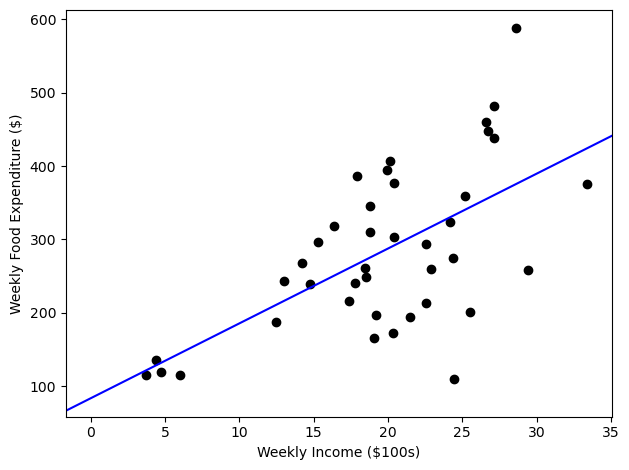

In [24]:
# Revisiting the same model
food_ols = smf.ols('food_exp ~ income', data=food).fit()

# Parameter estimates
print(food_ols.params, '\n')
food_ols_b1, food_ols_b2 = food_ols.params # extract estimates

# Regression summary
print(food_ols.summary())

# Plot fitted regression line
plt.scatter(x=food['income'], y=food['food_exp'], color='black')
plt.axline(xy1=(0, food_ols_b1), slope=food_ols_b2, color='blue') # intercept is (0, b1)
plt.ylabel('Weekly Food Expenditure ($)')
plt.xlabel('Weekly Income ($100s)')
plt.tight_layout()

/Users/randallr.rojas/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


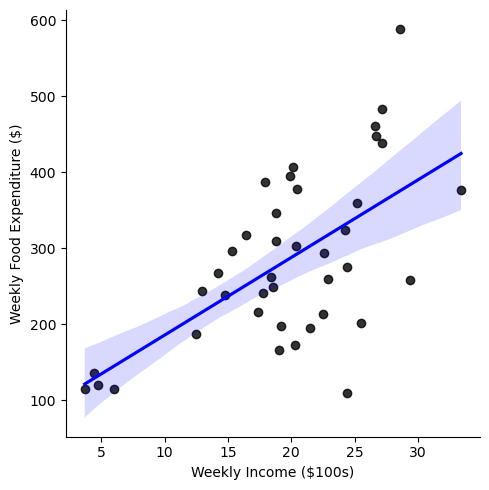

In [25]:
# With confidence interval
sns.lmplot(data=food, x='income', y='food_exp', ci=95, scatter_kws={'color':'black'}, line_kws={'color':'blue'})
plt.ylabel('Weekly Food Expenditure ($)')
plt.xlabel('Weekly Income ($100s)')
plt.show()

## 3.3 The Gauss-Markov Theorem

* Under our assumptions of the linear regression model, the estimators $b_{1}$ and $b_{2}$ have the smallest variance of all linear and unbiased estimators of $\beta_{1}$ and $\beta_{2}$. They are the **B**est **L**inear **U**nbiased **E**stimators (<font color="blue">BLUE</font>) of $\beta_{1}$ and $\beta_{2}$.
* The estimators $b_{1}$ and $b_{2}$ are best within their class because they have the minimum variance. When comparing two linear and unbiased estimators, we always want to use the one with the smaller variance, because that estimation rule gives us the higher probability of obtaining an estimate that is close to the true parameter value.
* For this to be the case, all of our assumptions should be true, except for the normality. For example, we need homoskedasticity.

## 3.4 Distribution of the Least Squares Estimators

* If we make the normality assumption, we get
\begin{align*}
b_2|x\phantom{-} &\sim \phantom{-} N\left(\beta_2,\frac{\sigma^2}{\sum(x_i-\bar x)^2}\right) \\
b_1|x\phantom{-} &\sim \phantom{-} N\left(\beta_1,\frac{\sigma^2\sum x_i^2}{N \sum(x_i-\bar x)^2}\right)
\end{align*}
* The Central Limit Theorem says that the above is approximately correct even if the errors are not normally distributed, as long as $N$ is sufficiently large.
* We can estimate $\sigma^2$ by $$\widehat{\sigma}^{2} = \frac{\sum_{i=1}^{N}\widehat{e}_{i}^{2}}{N-2}$$ where $$\widehat{e}_{i} = y_{i}-\widehat{y}_{i}=y_{i}-b_{1}-b_{2}x_{i}$$
    + It can be shown that $\widehat{\sigma}^{2}$ is an unbiased estimator for $\sigma^2$.
    + Note that the denominator is $N-2$, not $N$.
* We can then construct
\begin{align*}
\widehat{\mathrm{Var}}(b_2) \phantom{-} &= \phantom{-}  \frac{\widehat{\sigma^2}}{\sum(x_i-\bar x)^2} \\
\widehat{\mathrm{Var}}(b_1) \phantom{-} &= \phantom{-}  \widehat{\sigma^2}\frac{\sum x_i^2}{N \sum(x_i-\bar x)^2} \\
\widehat{\mathrm{Cov}}(b_1,b_2) \phantom{-} &= \phantom{-}  -\widehat{\sigma^2}\frac{\bar x}{\sum(x_i-\bar x)^2}
\end{align*}
* We often write
\begin{align*}
se(b_2) \phantom{-} &=\phantom{-} \sqrt{\widehat{\mathrm{Var}}(b_2)} \\
se(b_1) \phantom{-} &=\phantom{-} \sqrt{\widehat{\mathrm{Var}}(b_1)}
\end{align*}

In general, when determining how well the model fit the data, we look at:

* t-stats and respective $p$-values of the estimated parameters
* Coefficient of Determination: $R^2$
* $F$-stat of the model and respective p-value
* Plot of the residuals:
    + (1) Randomly distributed about 0 and
    + (2) Constant Variance
* Interpretability of the estimates
* Robustness of the model estimates
* High correlation between actual and predicted values

## 3.5 Prediction vs. Confidence Intervals

In Example 3.2 we showed the confidence interval for the predicted values. In that case, the confidence interval for the line was generated using bootstrapping. However, we can calculate the interval directly using the mean point estimates and the estimated standard error. With these calculations we must note that any predicted value, $\widehat{y}_i$, is a random variable since the value depends on the sample. This suggests that we should also estimate a corresponding *prediction interval* for $\widehat{y}_i$.

Consider for example, finding $y(x=x_0) = y_0 = \beta_1 + \beta_2 x_0$. Based on the SR assumptions (1)-(5), the confidence interval estimates are about $E[y_0]$, which is not random. We can define the *forecast error*  as $f= y_0-\widehat{y}_0 = (\beta_1+\beta_2 x_0 + e_0) - (\widehat{\beta}_1 + \widehat{\beta}_2x_0)$, where $E[f] =0$ and

$$\mathrm{Var}(f) = \sigma^{2} \left(1 + \frac{1}{N} + \frac{(x_0-\overline{x})^2}{\sum(x_i-\overline{x})^2} \right).$$

Since we do not know $\sigma^2$ we can estimate it (call it $\widehat{\sigma}^2$), and then we have an estimate for the *standard error of the forecast*, $se(f) = \sqrt{\widehat{\mathrm{Var}}(f)}$, from which we can compute the prediction interval for $\widehat{y}_0$ as $\widehat{y}_0 \pm t_c \times se(f)$, where $t_c = t_{1-\alpha/2, N-2}$. Below we show a general plot of prediction interval behavior.

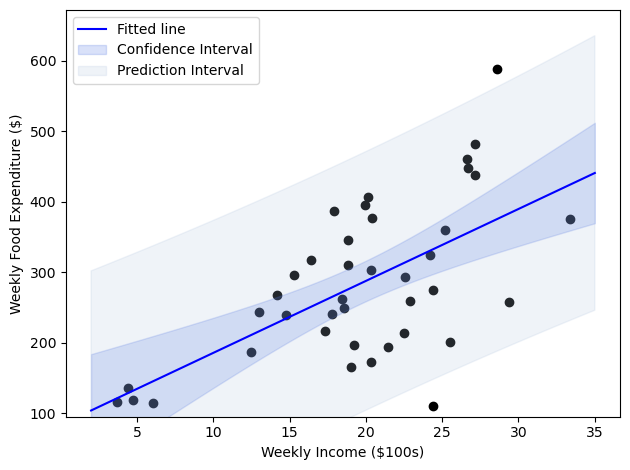

In [26]:
# Confidence vs Prediction Intervals

# Revisiting the same model
food_ols = smf.ols('food_exp ~ income', data=food).fit()

# Create data spanning all observed values of x, for estimation
food_predict = pd.DataFrame({'income':np.linspace(2, 35, 200)})
food_ols_predict = food_ols.get_prediction(food_predict)                       # generate predictions
food_ols_predict_intervals = food_ols_predict.summary_frame(alpha = 0.05)       # compute 95% intervals

# Extracting estimated intervals
food_predict['point_est'] = food_ols_predict_intervals['mean']     # point estimates
food_predict[['ci_lower', 'ci_upper']] = food_ols_predict_intervals[['mean_ci_lower', 'mean_ci_upper']]   # lower and upper CONFIDENCE intervals
food_predict[['pi_lower', 'pi_upper']] = food_ols_predict_intervals[['obs_ci_lower', 'obs_ci_upper']]     # lower and upper PREDICTION intervals

# Plotting
plt.scatter(x=food['income'], y=food['food_exp'], color='black')
plt.plot(food_predict['income'], food_predict['point_est'], color='blue', label='Fitted line')
plt.fill_between(food_predict['income'], food_predict['ci_lower'], food_predict['ci_upper'], color='royalblue', alpha=0.2, label='Confidence Interval')
plt.fill_between(food_predict['income'], food_predict['pi_lower'], food_predict['pi_upper'], color='lightsteelblue', alpha=0.2, label='Prediction Interval')
plt.ylabel('Weekly Food Expenditure ($)')
plt.xlabel('Weekly Income ($100s)')
plt.ylim((95, None))
plt.legend()
plt.tight_layout()

# We observe the prediction interval is wider than the confidence interval.

#### **Example:** Wage Equation

We will do the following example using the data `cps4_small`.

1. Estimate a wage equation, $wage  = \beta_1 + \beta_2 educ + e$ where $wage$ represents hourly wages in US dollars, and $educ$ the number of years of education. 
2. Overlay the LS line of the scatter plot of the data.
3. Estimate a $95\%$ confidence interval overlay it on the plot from (2)
4. Estimate a $95\%$ prediction interval overlay it on the plot from (3)
5. Interpret your intervals from (2) and (3)

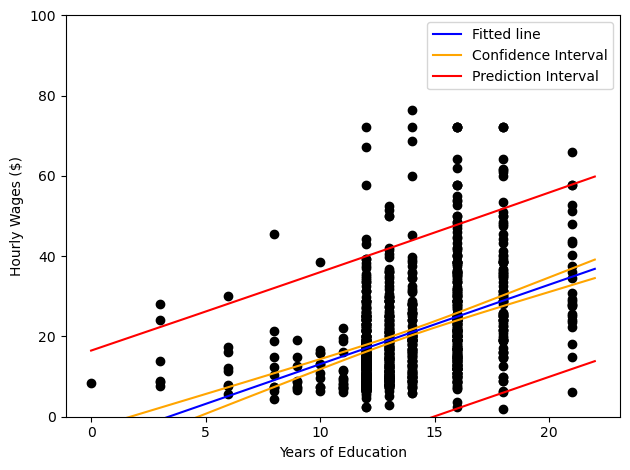

In [27]:
# Import data and fit model
cps4_small = pd.read_csv('data/cps4_small.csv')
cps4_ols = smf.ols('wage ~ educ', data=cps4_small).fit()

# Create data spanning all observed values of x, for estimation
cps4_predict = pd.DataFrame({'educ':np.linspace(0, 22, 200)})
cps4_ols_predict = cps4_ols.get_prediction(cps4_predict)                        # generate predictions
cps4_ols_predict_intervals = cps4_ols_predict.summary_frame(alpha = 0.05)       # compute 95% intervals

# Extracting estimated intervals
cps4_predict['point_est'] = cps4_ols_predict_intervals['mean']     # point estimates
cps4_predict[['ci_lower', 'ci_upper']] = cps4_ols_predict_intervals[['mean_ci_lower', 'mean_ci_upper']]   # lower and upper CONFIDENCE intervals
cps4_predict[['pi_lower', 'pi_upper']] = cps4_ols_predict_intervals[['obs_ci_lower', 'obs_ci_upper']]     # lower and upper PREDICTION intervals

# Plotting
plt.scatter(x=cps4_small['educ'], y=cps4_small['wage'], color='black')
plt.plot(cps4_predict['educ'], cps4_predict['point_est'], color='blue', label='Fitted line')
plt.plot(cps4_predict['educ'], cps4_predict['ci_lower'], color='orange', label='Confidence Interval')
plt.plot(cps4_predict['educ'], cps4_predict['ci_upper'], color='orange')
plt.plot(cps4_predict['educ'], cps4_predict['pi_lower'], color='red', label='Prediction Interval')
plt.plot(cps4_predict['educ'], cps4_predict['pi_upper'], color='red')
plt.ylabel('Hourly Wages ($)')
plt.xlabel('Years of Education')
plt.ylim((0, 100))
plt.legend()
plt.tight_layout()

# As expected, prediction interval is wider for the same level of confidence

# <font face="garamond" size="14" color="#122DAC">4. Random Sampling</font>

## 4.1 K-Fold Cross Validation

Another useful diagnostic tool is K-Fold Cross Validation. This is a test of how well the model generalizes to new data. Briefly, the data are separated into testing (we predict these values) and training sets (use these to estimate the model parameters). By comparing the true values to the predicted values, we have a measure of how well the model predicted the correct values (This method is known as the *Holdout Method*). Since this result can be biased based on the training set, a better option is to split the data into $k$ mutually exclusive random subsets, and repeat holdout method $k$ times.

<img src="images/L1_fig5.png" alt="k-Fold CV Illustration: Figure from Kaggle (S. Gunjal, 2020)" width="750">

#### Code Example

In [28]:
# Example: Crimes vs Population Density
## crmrte: (y) crimes committed per person 
## density: (x) people per square mile

# Import data
crime = pd.read_csv('data/crime.csv')

# Train-test split (from sklearn)
crime_train, crime_test = train_test_split(crime, test_size=0.25, random_state=90095)
print(crime_train.shape, crime_test.shape) # sample sizes

(472, 59) (158, 59)


                            OLS Regression Results                            
Dep. Variable:                 crmrte   R-squared:                       0.482
Model:                            OLS   Adj. R-squared:                  0.481
Method:                 Least Squares   F-statistic:                     436.7
Date:                Mon, 30 Sep 2024   Prob (F-statistic):           4.65e-69
Time:                        08:42:11   Log-Likelihood:                 1378.2
No. Observations:                 472   AIC:                            -2752.
Df Residuals:                     470   BIC:                            -2744.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0190      0.001     22.555      0.0

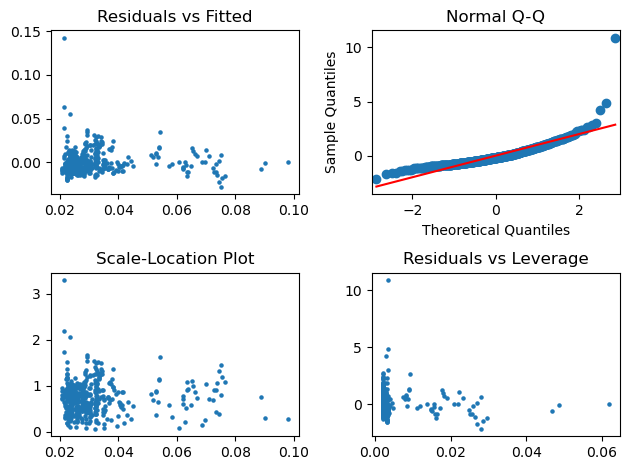

In [29]:
# Fit OLS model
crime_ols1 = smf.ols('crmrte ~ density', data=crime_train).fit()
crime_ols1_std_resid = crime_ols1.get_influence().resid_studentized_internal # standardized residuals
crime_ols1_lev = crime_ols1.get_influence().hat_matrix_diag # leverage values

# Summary
print(crime_ols1.summary())

# Diagnostic plots
fig5, ax5 = plt.subplots(2, 2)
ax5[0,0].scatter(x=crime_ols1.fittedvalues, y=crime_ols1.resid, s=5)
ax5[0,0].set_title('Residuals vs Fitted')
sm.qqplot(crime_ols1_std_resid, line='s', ax=ax5[0,1])
ax5[0,1].set_title('Normal Q-Q')
ax5[1,0].scatter(x=crime_ols1.fittedvalues, y=np.sqrt(np.abs(crime_ols1_std_resid)), s=5) # y = sqrt( |std. resid| )
ax5[1,0].set_title('Scale-Location Plot')
ax5[1,1].scatter(x=crime_ols1_lev, y=crime_ols1_std_resid, s=5)
ax5[1,1].set_title('Residuals vs Leverage')
plt.tight_layout()

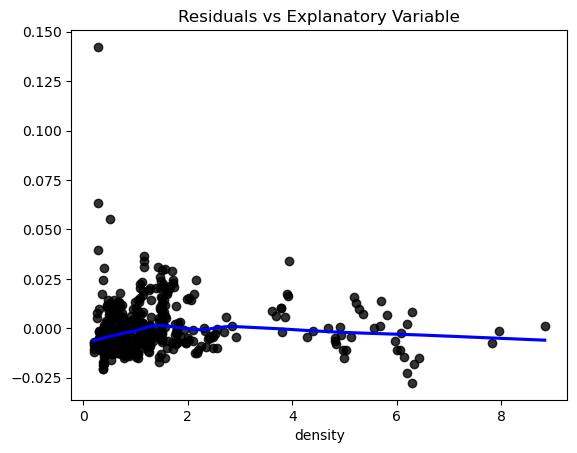

In [30]:
# A closer look at the residuals
sns.regplot(x=crime_train['density'], y=crime_ols1.resid, lowess=True, scatter=True, color='blue', scatter_kws={'color':'black'})
plt.title('Residuals vs Explanatory Variable')
plt.show()

In [31]:
# RMSE = Root Mean Square Error = sqrt(MSE)
# = on average, how far the predicted value is from the true value

# Note: typically training errors are smaller than testing errors

# Train RMSE
crime_train_RMSE = np.sqrt(np.mean(crime_ols1.resid ** 2))
print(f"Train RMSE = {crime_train_RMSE:.6}")
# On average, the predicted value is off by 0.0131

# Test RMSE
crime_test_pred = crime_ols1.predict(crime_test)
crime_test_RMSE = np.sqrt(np.mean((crime_test['crmrte'] - crime_test_pred) ** 2))
print(f"Test RMSE = {crime_test_RMSE:.6}\n")
# On average, the predicted value is off by 0.0130

# 5-fold cross validation
ols_mod = LinearRegression()
crime_cv_rmse = cross_val_score(ols_mod, X=crime['density'].to_numpy().reshape(-1,1), y=crime['crmrte'],
                                cv=5, scoring='neg_root_mean_squared_error')
# Output is (negative) RMSE for each hold-out sample
# Can use other scoring functions, see here: https://scikit-learn.org/stable/modules/model_evaluation.html

# Print RMSE for each CV fold
for i, rmse in enumerate(crime_cv_rmse):
    print(f'Fold {i+1} RMSE = {np.abs(rmse):.6}')

# Print overall (mean) CV RMSE
crime_cv_rmse_overall = np.abs(np.mean(crime_cv_rmse))
print(f'Overall CV RMSE = {crime_cv_rmse_overall:.6}')
# On average, the predicted value is off by 0.0129

Train RMSE = 0.0130527
Test RMSE = 0.0130033

Fold 1 RMSE = 0.00855318
Fold 2 RMSE = 0.0147383
Fold 3 RMSE = 0.0107908
Fold 4 RMSE = 0.018521
Fold 5 RMSE = 0.0117023
Overall CV RMSE = 0.0128611


CV RMSE = 11.657494175348624


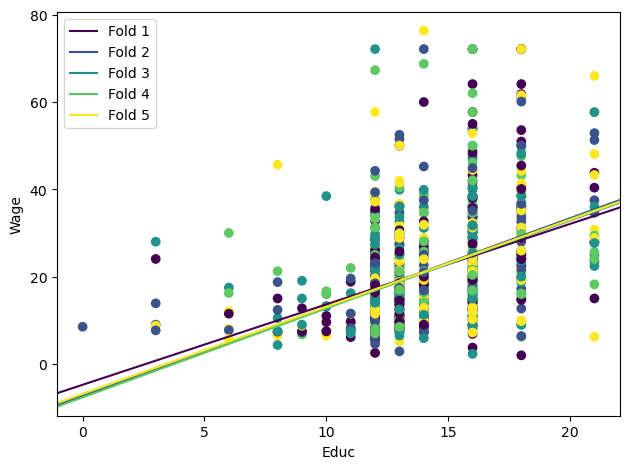

In [32]:
# Cross validation example using 'cps4_small'

cps4_X = cps4_small['educ'].to_numpy().reshape(-1,1) # as numpy array

# 5-Fold initialization
kf =  KFold(n_splits=5, shuffle=True, random_state=10)

# Initialize lists for appending
fold_assignments = np.zeros(cps4_small.shape[0])
rmse_list = []
intercept_list = []
coefficient_list = []

for fold, (train_index, test_index) in enumerate(kf.split(cps4_small)):
    fold_assignments[test_index] = fold
    
    # Split into train and test samples
    X_train, X_test = cps4_X[train_index], cps4_X[test_index]
    y_train, y_test = cps4_small['wage'][train_index], cps4_small['wage'][test_index]
    
    # Model fitting & evaluation
    model = LinearRegression().fit(X_train, y_train) # train model
    y_pred = model.predict(X_test) # predicted y
    fold_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred)) # RMSE

    # Append model info
    rmse_list.append(fold_rmse)
    intercept_list.append(model.intercept_)
    coefficient_list.append(model.coef_[0]) # only one coefficient

# Insert fold assignments
cps4_folds = cps4_small.copy()[['educ', 'wage']]
cps4_folds['fold'] = fold_assignments

# Plotting
fold_c = ['#440154FF', '#3B528BFF', '#21908CFF', '#5DC863FF', '#FDE725FF']
plt.scatter(x=cps4_folds['educ'], y=cps4_folds['wage'], c=cps4_folds['fold'])
for i,params in enumerate(zip(intercept_list, coefficient_list)):
    plt.axline(xy1=(0, params[0]), slope=params[1], color=fold_c[i], label=f'Fold {i+1}')
plt.ylabel('Wage')
plt.xlabel('Educ')
plt.legend()
plt.tight_layout()

## Scatter plot has the true values (colored based on respective hold-out fold)
## Lines are the models for each fold

## We need to check if the model's prediction accuracy isn't varying too much for any one particular sample,
## and if the lines of best fit don't vary too much with respect the the slope and level.

# CV results
print(f'CV RMSE = {np.mean(rmse_list)}')

CV RMSE = 14.970075346410379


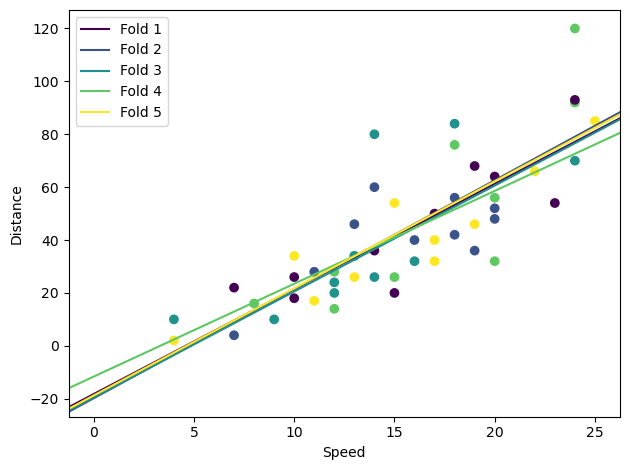

In [33]:
# Example: Stopping Distance vs. Speed 
## Repeat of the above example using 'cars' data set

# Import data
cars = pd.read_csv('data/cars.csv')
cars_X = cars['speed'].to_numpy().reshape(-1,1) # x-variable as numpy array

# Initialize lists for appending
fold_assignments = np.zeros(cars.shape[0])
rmse_list = []
intercept_list = []
coefficient_list = []

# Using the same 5-fold scheme as before
for fold, (train_index, test_index) in enumerate(kf.split(cars)):
    fold_assignments[test_index] = fold
    
    # Split into train and test samples
    X_train, X_test = cars_X[train_index], cars_X[test_index]
    y_train, y_test = cars['dist'][train_index], cars['dist'][test_index]
    
    # Model fitting & evaluation
    model = LinearRegression().fit(X_train, y_train) # train model
    y_pred = model.predict(X_test) # predicted y
    fold_rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred)) # RMSE

    # Append model info
    rmse_list.append(fold_rmse)
    intercept_list.append(model.intercept_)
    coefficient_list.append(model.coef_[0]) # only one coefficient

# Insert fold assignments
cars_folds = cars.copy()
cars_folds['fold'] = fold_assignments

# Plotting
fold_c = ['#440154FF', '#3B528BFF', '#21908CFF', '#5DC863FF', '#FDE725FF']
plt.scatter(x=cars_folds['speed'], y=cars_folds['dist'], c=cars_folds['fold'])
for i,params in enumerate(zip(intercept_list, coefficient_list)):
    plt.axline(xy1=(0, params[0]), slope=params[1], color=fold_c[i], label=f'Fold {i+1}')
plt.ylabel('Distance')
plt.xlabel('Speed')
plt.legend()
plt.tight_layout()

## Scatter plot has the true values (colored based on respective hold-out fold)
## Lines are the models for each fold

# CV results
print(f'CV RMSE = {np.mean(rmse_list)}')

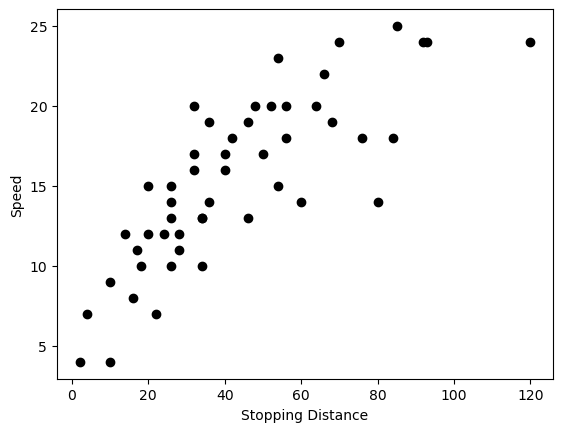

In [34]:
# Example: Speed vs. Stopping Distance

plt.scatter(x=cars['dist'], y=cars['speed'], color='black')
plt.ylabel('Speed')
plt.xlabel('Stopping Distance')
plt.show()
# We will try fitting higher-order polynomials to the data

[[4.0000e+00 1.6000e+01 6.4000e+01 2.5600e+02 1.0240e+03]
 [4.0000e+00 1.6000e+01 6.4000e+01 2.5600e+02 1.0240e+03]
 [7.0000e+00 4.9000e+01 3.4300e+02 2.4010e+03 1.6807e+04]
 [7.0000e+00 4.9000e+01 3.4300e+02 2.4010e+03 1.6807e+04]]


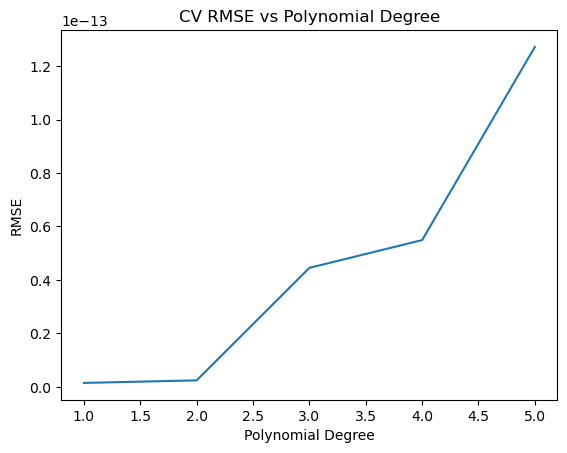

In [35]:
# We'll try degrees 1 - 5 and use CV to determine the optimal

# Compute higher powers
poly = preprocessing.PolynomialFeatures(5, include_bias=False)
cars_X_poly = poly.fit_transform(cars_X)
print(cars_X_poly[:4,:]) # print first 4 rows

mod_OLS = LinearRegression()
cars_CV_scores = np.zeros(5)

# Run through higher orders
for i in range(cars_X_poly.shape[1]):
    cv_X = cars_X_poly[:,:(i + 1)] # subset the columns
    cv_nRMSE = cross_val_score(mod_OLS, X=cv_X, y=cars['speed'], scoring='neg_root_mean_squared_error', cv=KFold(5))
    cars_CV_scores[i] = cv_nRMSE.mean()

# Plotting
plt.plot(range(1,6), np.abs(cars_CV_scores))
plt.title('CV RMSE vs Polynomial Degree')
plt.xlabel('Polynomial Degree')
plt.ylabel('RMSE')
plt.show()

## The plot suggest that a low degree polynomial fits best
## At higher orders, we are overfitting and thus lose predictive performance

## 4.2 Boostrapping Regression Models

In general, for any regression model estimated, it is a good idea to also include bootstrap estimates as way to test for the robustness of the estimates. The core principle being simple random sampling with replacement from the original dataset, and for each sample, estimating the same regression model and then collecting the usual statistics.

#### Code Example: *The Boostrapped Model*

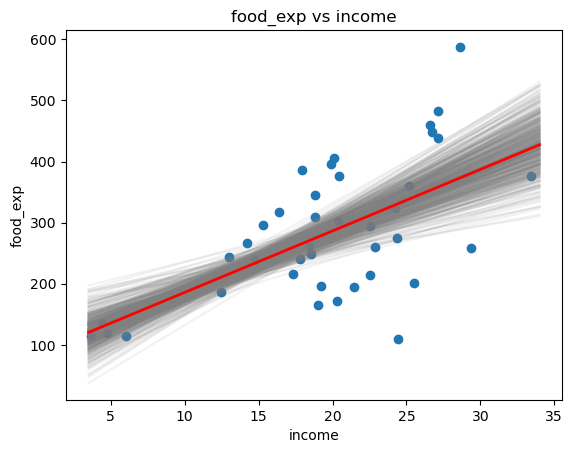

In [36]:
# We will be using the 'food' data set

random.seed(90095)
n_boot = 500 # number of bootstraps

# initializations
boot_rmse = []
boot_b1 = []
boot_b2 = []
boot_sig2hat = [] # sigma^2 hat estimates (or std error ^2)
boot_r2 = [] # R^2 (no need to adjust)

food_span_x = pd.DataFrame({'income':np.linspace(3.5, 34, 200)}) # x spanning 3.5 through 34 for graphing

for iter in range(n_boot):
   # Sampling with replacement
   food_sample = food.sample(n=food.shape[0], replace=True) # `sample` method for pandas DataFrame
   food_sample_ols = smf.ols('food_exp ~ income', data=food_sample).fit() # fit model

   # Append coefficients
   boot_b1.append(food_sample_ols.params[0])          # intercept
   boot_b2.append(food_sample_ols.params[1])          # slope
   # Performance measures
   boot_sig2hat.append(food_sample_ols.scale)         # scale = estimated sigma^2
   boot_rmse.append(np.sqrt(np.mean(food_sample_ols.resid ** 2))) # RMSE
   boot_r2.append(food_sample_ols.rsquared)           # R^2

   # Plot a greyed out line for this iteration
   food_sample_yhat = food_sample_ols.predict(food_span_x)
   plt.plot(food_span_x, food_sample_yhat, color='grey', alpha=0.1)

# Fit averaged model
food_ols_span_y = np.mean(boot_b1) + food_span_x * np.mean(boot_b2)

# Plotting the fitted lines
plt.scatter(food['income'], food['food_exp'])
plt.plot(food_span_x, food_ols_span_y, color='r', linewidth=2)
plt.xlabel('income')
plt.ylabel('food_exp')
plt.title('food_exp vs income')
plt.show()

#### Code Example: *The Boostrapped Distributions*

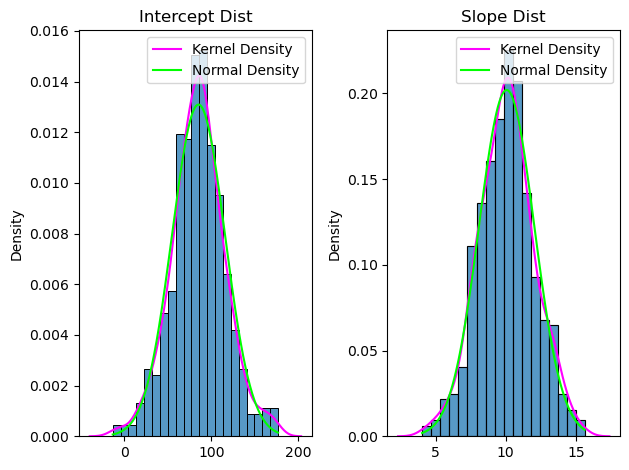

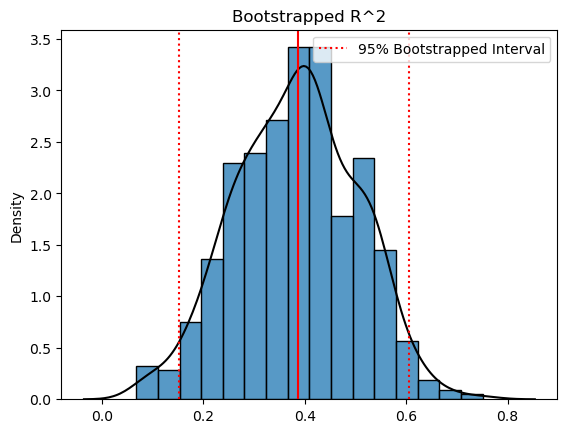

--- sigma hat ---
estimate:		86.876
std error:		9.7187
median:			86.687
2.5 percentile:		66.773
97.5 percentile:	105.26


In [37]:
# Next the distributions of the estimates

# For plotting normal PDFs
b1_range = np.arange(np.min(boot_b1), np.max(boot_b1), 0.1)
b2_range = np.arange(np.min(boot_b2), np.max(boot_b2), 0.1)

# Plotting beta estimates
fig6, ax6 = plt.subplots(1, 2)
sns.histplot(boot_b1, stat='density', kde=False, ax=ax6[0])
sns.kdeplot(boot_b1, color='fuchsia', ax=ax6[0], label='Kernel Density')
sns.lineplot(x=b1_range, y=norm.pdf(b1_range, np.mean(boot_b1), np.std(boot_b1)), color='lime',ax=ax6[0], label='Normal Density')
ax6[0].set_title('Intercept Dist')
sns.histplot(boot_b2, stat='density', kde=False, ax=ax6[1])
sns.kdeplot(boot_b2, color='fuchsia', ax=ax6[1], label='Kernel Density')
sns.lineplot(x=b2_range, y=norm.pdf(b2_range, np.mean(boot_b2), np.std(boot_b2)), color='lime',ax=ax6[1], label='Normal Density')
ax6[1].set_title('Slope Dist')
plt.tight_layout()
plt.show()

# Bootstrap for distribution of R^2 (coefficient of determination)
sns.histplot(boot_r2, stat='density', kde=False)
sns.kdeplot(boot_r2, color='black')
plt.axvline(x=np.quantile(boot_r2, q=0.025), color='red', linestyle=':', label='95% Bootstrapped Interval')
plt.axvline(x=np.quantile(boot_r2, q=0.5), color='red')
plt.axvline(x=np.quantile(boot_r2, q=0.975), color='red', linestyle=':')
plt.title('Bootstrapped R^2')
plt.legend()
plt.show()

# Bootstrap for estimated residual standard deviation
boot_stdhat = np.sqrt(boot_sig2hat)
print('--- sigma hat ---\n' +
      f'estimate:\t\t{boot_stdhat.mean():.5}\n' +
      f'std error:\t\t{boot_stdhat.std():.5}\n' +
      f'median:\t\t\t{np.quantile(boot_stdhat, q=0.5):.5}\n' +
      f'2.5 percentile:\t\t{np.quantile(boot_stdhat, q=0.025):.5}\n' +
      f'97.5 percentile:\t{np.quantile(boot_stdhat, q=0.975):.5}'
      )

# <font face="garamond" size="14" color="#122DAC">5. Estimating Nonlinear Relationships</font>

When the data are not suitable for a linear model, we can consider non-linear transformations on $y$ and/or $x$. In econometrics 4 very popular non-linear models are the (1) log-log, (2) log-linear, (3) linear-log, and (4) quadratic models. The table below shows a summary of these models and their respective interpretations.

<img src="images/L1_fig6.png" alt="Summary of Common Transformations for Linear Models" width="750">

Recall that the elasticity, $\varepsilon$, can be computed as $\varepsilon = \text{slope} \times \frac{x}{y}$. For example, a quadratic model for the house prices such as
$$
PRICE = \alpha_{1}+\alpha_{2}SQFT^{2}+e
$$
has a slope given by
$$
\frac{d\left(\widehat{PRICE}\right)}{d SQRT}=2\widehat{\alpha_2}SQFT
$$
and thus, the respective elasticity is given by
$$
\varepsilon=2\widehat{\alpha_2}SQFT\left(\frac{SQFT}{\widehat{PRICE}}\right).
$$

As an example, let's estimate the quadratic regression model above.



#### Code Example

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.692
Model:                            OLS   Adj. R-squared:                  0.692
Method:                 Least Squares   F-statistic:                     2426.
Date:                Mon, 30 Sep 2024   Prob (F-statistic):          3.37e-278
Time:                        08:42:22   Log-Likelihood:                -13552.
No. Observations:                1080   AIC:                         2.711e+04
Df Residuals:                    1078   BIC:                         2.712e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     5.578e+04   2890.441     19.297   

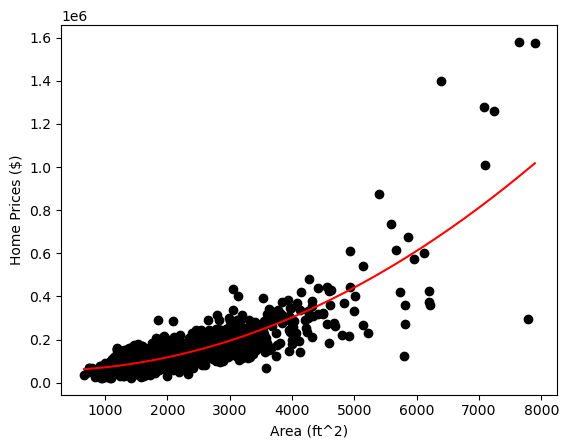

In [38]:
# Using 'br' data set
# Home Prices (y=price) vs. Living Area (x=sqft)

# Import data and fit model
br = pd.read_csv('data/br.csv')
br_ols = smf.ols('price ~ I(sqft**2)', data=br).fit()
# Note: I() in the formula operates like in R, applying the transformation to the column values

print(br_ols.summary())

# Plotting the fitted model
br_x = np.linspace(min(br['sqft']), max(br['sqft']), 200)
br_ols_curve = br_ols.params[0] + br_ols.params[1] * (br_x**2) # b1 + b2 * x^2
plt.scatter(x=br['sqft'], y=br['price'], color='black')
plt.plot(br_x, br_ols_curve, color='r')
plt.ylabel('Home Prices ($)')
plt.xlabel('Area (ft^2)')
plt.show()

# Q1: Is the quadratic fit a good one?
## A1: From the scatterplot we can see that for  homes with sqft>4000, the spread increases and the number
## of observations decreases. This suggests that our fit will worsen as we consider larger values of x
## beyond ~ 4000ft^2.

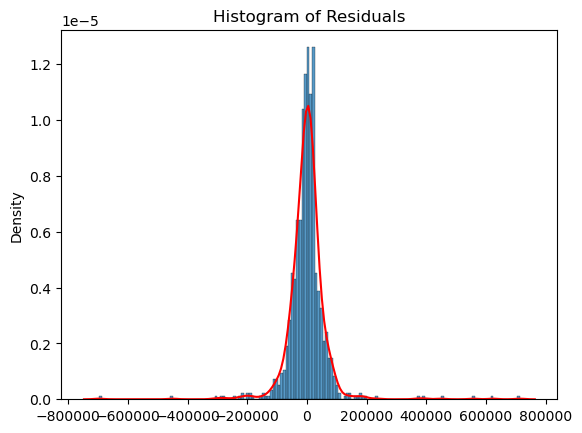

SignificanceResult(statistic=61385.02916471469, pvalue=0.0)

In [39]:
# Q2: Are the residuals normally distributed?

## A2.1: The first way we can answer is by looking at their distribution.
sns.histplot(br_ols.resid, stat='density')
sns.kdeplot(br_ols.resid, color='r')
plt.title('Histogram of Residuals')
plt.show()
# Looks to be fairly normally distributed.

## A2.2: The second way we can answer is with a formal statistical test, the Jarque-Bera test.
# H0: normally distributed
stats.jarque_bera(br_ols.resid)

# With a p-value of approx. 0, reject H0. So residuals are NOT normally distributed.
# Note: We get the JB statistic and p-value in the model summary table.

In [40]:
# We can also compute traditional metrics such as predicted values and elasticities

br_sqftx = np.array([2000, 4000, 6000])                             # given values for sqft
br_pricex = br_ols.params[0] + br_ols.params[1] * (br_sqftx**2)     # b1 + b2 * x^2
br_DpriceDsqft = 2 * br_ols.params[1] * br_sqftx                    # marginal effect of sqft on price
br_elasticity = br_DpriceDsqft * br_sqftx / br_pricex               # e = (dy/dx) * (x/y)

for x,d,e in zip(br_sqftx, br_DpriceDsqft, br_elasticity):
    print(f'SQFT = {x},  DpriceDsqft = {d:.6},  elasticity = {e:.5}')

SQFT = 2000,  DpriceDsqft = 61.6852,  elasticity = 1.0503
SQFT = 4000,  DpriceDsqft = 123.37,  elasticity = 1.6313
SQFT = 6000,  DpriceDsqft = 185.056,  elasticity = 1.8174


#### Code Example

                            OLS Regression Results                            
Dep. Variable:               food_exp   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     21.05
Date:                Mon, 30 Sep 2024   Prob (F-statistic):           4.76e-05
Time:                        08:42:24   Log-Likelihood:                -236.41
No. Observations:                  40   AIC:                             476.8
Df Residuals:                      38   BIC:                             480.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           -97.1864     84.23

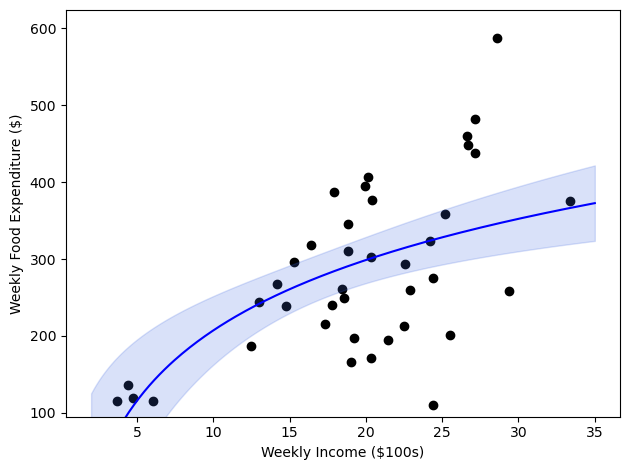

In [41]:
# We will be using the 'food' data set from earlier
# Recall: Weekly Food Expenditure (y=food_exp in $) vs. Income (x=income in units of $100)

# We will consider a Linear-Log Model:      y = b1 + b2 * log(x)
food_LinLog = smf.ols('food_exp ~ I(np.log(income))', data=food).fit()
print(food_LinLog.summary())

# Create data spanning all observed values of x, for estimation
food_predict = pd.DataFrame({'income':np.linspace(2, 35, 200)})
food_LinLog_predict = food_LinLog.get_prediction(food_predict)                             # generate predictions
food_LinLog_predict_intervals = food_LinLog_predict.summary_frame(alpha = 0.05)         # compute 95% intervals
# Extract point estimate, and lower and upper CONFIDENCE intervals
food_predict[['point_est', 'ci_lower', 'ci_upper']] = food_LinLog_predict_intervals[['mean', 'mean_ci_lower', 'mean_ci_upper']]

# Plotting
plt.scatter(x=food['income'], y=food['food_exp'], color='black')
plt.plot(food_predict['income'], food_predict['point_est'], color='blue', label='Fitted line')
plt.fill_between(food_predict['income'], food_predict['ci_lower'], food_predict['ci_upper'], color='royalblue', alpha=0.2)
plt.ylabel('Weekly Food Expenditure ($)')
plt.xlabel('Weekly Income ($100s)')
plt.ylim((95, None))
plt.tight_layout()

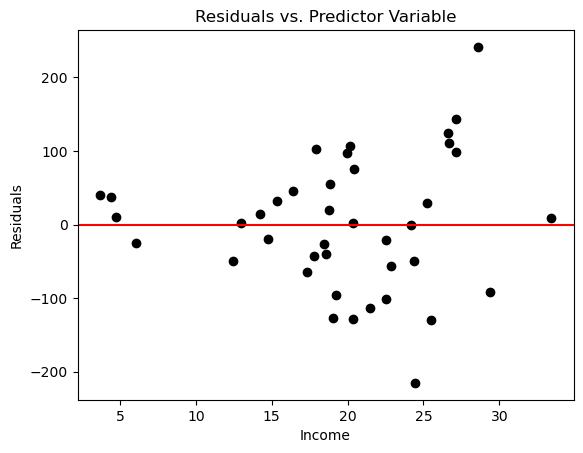

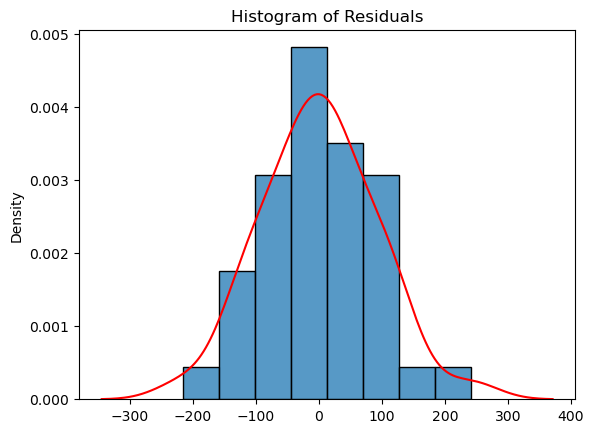

SignificanceResult(statistic=0.1998881820045199, pvalue=0.9048880080033236)

In [42]:
## Interpretation 1:    For a household with $1000 weekly income, we expect an additional weekly food
##                      spending of $13.22 for an additional $100 increase in weekly income.
## Interpretation 2:    For a 1% increase in income, we expect food expenditure to increase by $1.32/week.

# Next we will look at the residuals
plt.scatter(x=food['income'], y=food_LinLog.resid, color='black')
plt.axhline(y=0.0, color='r')
plt.title('Residuals vs. Predictor Variable')
plt.xlabel('Income')
plt.ylabel('Residuals')
plt.show()

# Histogram of residuals
sns.histplot(food_LinLog.resid, stat='density')
sns.kdeplot(food_LinLog.resid, color='r')
plt.title('Histogram of Residuals')
plt.show()

# Lastly, a Jarque-Bera test (H0: normality)
stats.jarque_bera(food_LinLog.resid)
# p-value = 0.9 > 0.05
# Fail to reject H0

## 5.1 Logarithms

In econometrics, logarithms are very useful when dealing with variables that span different orders of magnitude yet must be included in the regression model. For example consider a model that includes the predictors GDP (on the scale of $10^{10}$) and real interest rates (on the scale of $10^{-2}$). Logarithms can help us mitigate violations to the constant variance assumption often used in Least Squares. By default, `numpy` and similar modules generally have the `log` method employing the natural log.

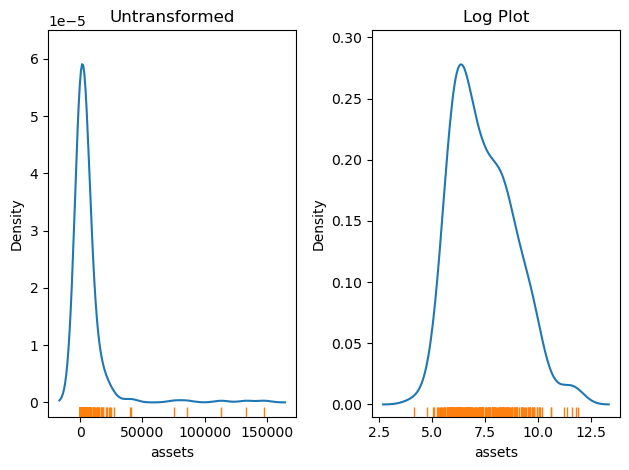

In [43]:
# Here we look at the 'ornstein' data, which includes financial assets of 248 Canadian companies.

fig7, ax7 = plt.subplots(1, 2)
sns.kdeplot(ornstein['assets'], ax=ax7[0])
sns.rugplot(ornstein['assets'], ax=ax7[0])
ax7[0].set_ylim((-2.5e-6, None))
ax7[0].set_title('Untransformed')
sns.kdeplot(np.log(ornstein['assets']), ax=ax7[1])
sns.rugplot(np.log(ornstein['assets']), ax=ax7[1])
ax7[1].set_ylim((-0.01, None))
ax7[1].set_title('Log Plot')
plt.tight_layout()

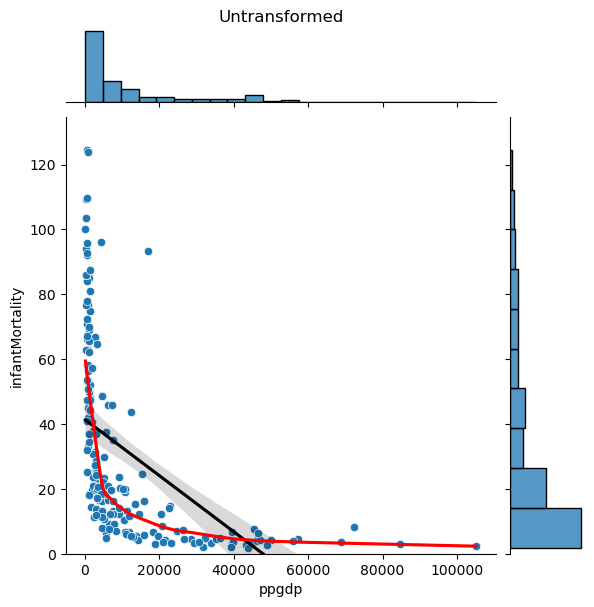

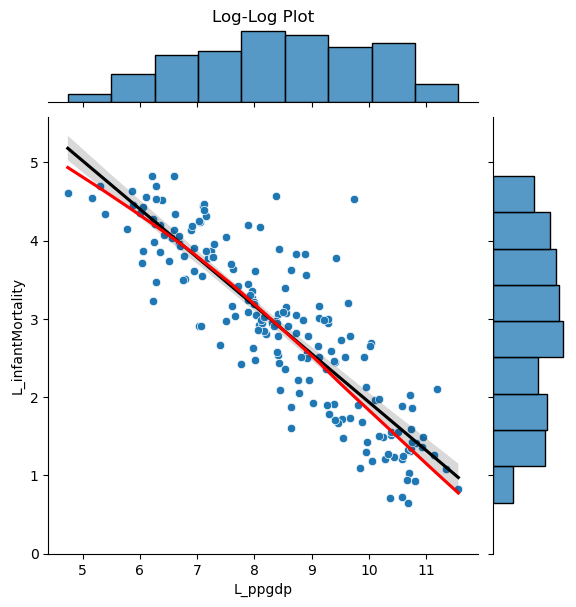

In [44]:
# We'll also look at the UN data set ('UN'), comparing infant mortality to per-capita GDP

# Importing
un = pd.read_csv('data/un.csv')
# Apply transformation
un2 = un.copy()
un2['L_infantMortality'] = np.log(un['infantMortality']); un2['L_ppgdp'] = np.log(un['ppgdp'])

# Plotting untransformed data
g1 = sns.jointplot(data=un, x='ppgdp', y='infantMortality')
g1.plot_joint(sns.scatterplot)
g1.plot_joint(sns.regplot, fit_reg=True, scatter=False, color='black')
g1.plot_joint(sns.regplot, lowess=True, scatter=False, color='red')
plt.ylim((0,None))
plt.title('Untransformed', y=1.2)
plt.show()

# Plotting transformed data

g2 = sns.jointplot(data=un2, x='L_ppgdp', y='L_infantMortality')
g2.plot_joint(sns.scatterplot)
g2.plot_joint(sns.regplot, fit_reg=True, scatter=False, color='black')
g2.plot_joint(sns.regplot, lowess=True, scatter=False, color='red')
plt.ylim((0,None))
plt.title('Log-Log Plot', y=1.2)
plt.show()

## 5.2 Power Transformations

Power transformations of the predictors and/or response variable(s) can help improve their respective distributions for modeling/estimation purposes (e.g., Least Squares estimates of regression coefficients) and sampling/robustness (e.g., bootstrapping and Bayesian inference). A popular transformation is the Box-Cox scale power transformation given by:

$$
T_{BC}(x,\lambda) = x^{(\lambda)}=\begin{cases}
\frac{x^\lambda - 1}{\lambda} \phantom- \text{ when }\lambda \not= 0, \\
\ln(x) \phantom- \text{ when }\lambda = 0.
\end{cases}
$$

We can try different values of $\lambda$ to guage which power transformation is more appropriate. Generally, we would prefer more "natural" values rather than exact decimals (e.g., 0 instead of 0.0012, or 0.5 instead of 0.497). For one, we do not want to overfit the data with this transformation, and secondly, we would prefer our treatment of the data to be as simple as possible, within reason. We can test if two values of lambda are roughly equivalent with a *likelihood ratio test*. The following is the procedure for transformations of a single variable:

1. Compute the estimated optimal $\lambda$, usually with maximum likelihood estimation (MLE). We will call it $\lambda_0$
2. Let $\hat\lambda$ be the value we are trying to test (e.g., estimated $\lambda_0=0.01$ but we want to try $\hat\lambda=0$). Compute the log-likelihood for both values of lambda, $L_0$ and $\hat L$ for the respective value of $\lambda$.
3. Compute the likelihood ratio statistic as follows: $$T=2(L_0 - \hat L).$$
4. Compute the p-value using a $\chi^2$ distribution with 1 degree of freedom: $p=P(\chi^2_{\nu=1}\geq T)$.

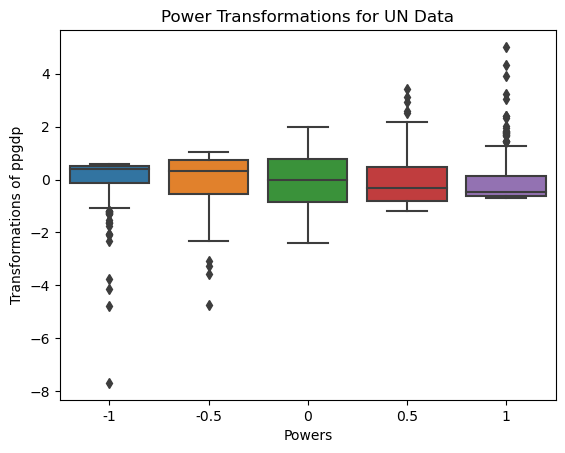

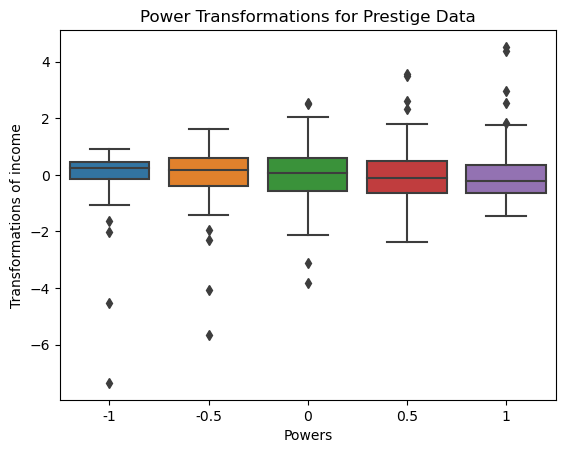

In [45]:
# Example: UN data set
un_boxcox = pd.DataFrame({
    '-1':stats.boxcox(un['ppgdp'], lmbda=-1),
    '-0.5':stats.boxcox(un['ppgdp'], lmbda=-0.5),
    '0':stats.boxcox(un['ppgdp'], lmbda=0),
    '0.5':stats.boxcox(un['ppgdp'], lmbda=0.5),
    '1':stats.boxcox(un['ppgdp'], lmbda=1)
}).apply(preprocessing.scale, axis=0) # center and scale data

# Plotting
sns.boxplot(un_boxcox)
plt.ylabel('Transformations of ppgdp')
plt.xlabel('Powers')
plt.title('Power Transformations for UN Data')
plt.show()

# Example: prestige data set
prestige_boxcox = pd.DataFrame({
    '-1':stats.boxcox(prestige['income'], lmbda=-1),
    '-0.5':stats.boxcox(prestige['income'], lmbda=-0.5),
    '0':stats.boxcox(prestige['income'], lmbda=0),
    '0.5':stats.boxcox(prestige['income'], lmbda=0.5),
    '1':stats.boxcox(prestige['income'], lmbda=1)
}).apply(preprocessing.scale, axis=0) # center and scale data

# Plotting
sns.boxplot(prestige_boxcox)
plt.ylabel('Transformations of income')
plt.xlabel('Powers')
plt.title('Power Transformations for Prestige Data')
plt.show()

Often times our variables take on negative values (e.g., S&P 500 returns), yet transformations such as logs would not work. Instead we can use the Yeo-Johnson transformations: $T_{BC}(x+1,\lambda)$ for nonnegative values of $x$ and $T_{BC}(-x+1,2-\lambda)$ for negative values of x.

$$
T_{YJ}(x,\lambda) = \begin{cases}
T_{BC}(x+1,\lambda) \phantom- \text{ for } x \geq 0, \\
T_{BC}(-x+1,2-\lambda) \phantom- \text{ for }x < 0.
\end{cases}
$$

In [46]:
x = np.arange(-5,6)
x_yj = stats.yeojohnson(x, lmbda=3)

pd.DataFrame({'untransformed':x, 'yeo-johnson':x_yj})

untransformed  yeo-johnson
0              -5    -0.833333
1              -4    -0.800000
2              -3    -0.750000
3              -2    -0.666667
4              -1    -0.500000
5               0     0.000000
6               1     2.333333
7               2     8.666667
8               3    21.000000
9               4    41.333333
10              5    71.666667

For regression purposes, transformations for normality, linearity and/or constant variance can be easily implemented and tested statistically with methods in the `stats` module from the `scipy` library. For example, consider the variable infant mortality from the UN dataset. 

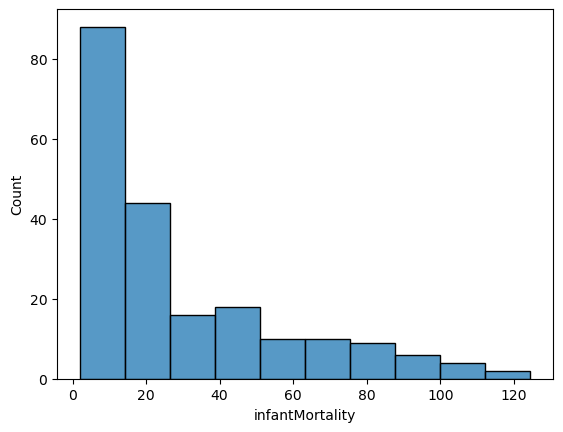

In [47]:
# Histogram of infant mortality
sns.histplot(un['infantMortality'])
plt.show()

# Histogram shows a right-skewed distribution. Therefore, we can try...
# (1) testing if transformation is needed and
# (2) if transformation is needed, performing it

In [48]:
# Testing the power transformations
un_infMort = un['infantMortality'].dropna() # remove missing values
_, un_lambda, un_ci = stats.boxcox(un_infMort, alpha=0.05)

# Print optimal results
print(f'estimated power = {un_lambda:.4}\n' + f'rounded power = {np.round(un_lambda,1)}\n' +
      f'Confidence interval = {np.round(un_ci, 4)}')

# Compute log-likelihoods
un_Lopt_ll = stats.boxcox_llf(lmb=un_lambda, data=un_infMort) # optimal lambda
un_L0_ll = stats.boxcox_llf(lmb=0, data=un_infMort) # lambda = 0
un_L05_ll = stats.boxcox_llf(lmb=0.5, data=un_infMort) # lambda = 0.5
un_L1_ll = stats.boxcox_llf(lmb=1, data=un_infMort) # lambda = 1
un_test_lambda = [0, 0.5, 1] # combine into one list

# Compute likelihood-ratio test statistics: T = 2 * (LogLik_optimal - LogLik_)
un_L0_stat = 2 * (un_Lopt_ll - un_L0_ll)
un_L05_stat = 2 * (un_Lopt_ll - un_L05_ll)
un_L1_stat = 2 * (un_Lopt_ll - un_L1_ll)
un_test_stat = [un_L0_stat, un_L05_stat, un_L1_stat] # combine into one list

# Compute p-values
un_L0_p = 1 - stats.chi2.cdf(un_L0_stat, df=1)
un_L05_p = 1 - stats.chi2.cdf(un_L05_stat, df=1)
un_L1_p = 1 - stats.chi2.cdf(un_L1_stat, df=1)
un_test_p = [un_L0_p, un_L05_p, un_L1_p] # combine into one list


# Print results
print('\nLambda \t Test Stat \t p-value')
for p in zip(un_test_lambda, un_test_stat, un_test_p):
    print(f'{p[0]} \t {p[1]:.6} \t {p[2]:.4}')

# Only lambda = 0 is close enough to be used

estimated power = 0.04678
rounded power = 0.0
Confidence interval = [-0.0876  0.1819]

Lambda 	 Test Stat 	 p-value
0 	 0.464463 	 0.4955
0.5 	 41.9583 	 9.324e-11
1 	 172.814 	 0.0


In the case of Multiple Regression, we may need to transform more than one variable at the same time (each with its own power-law). For example, we can look at the Multivariate Box Cox `Highway1` data. The following example is implemented in R, and takes from the `bcPower` documentation.

In [49]:
%%R
# Multivariate Box Cox uses Highway1 data
# See: https://www.rdocumentation.org/packages/car/versions/2.1-6/topics/Highway1

library(carData) # contains data set
library(car) # contains `powerTransform` and `testTransform`

data(Highway1)
summary(powerTransform(cbind(len, adt, trks, sigs1) ~ 1, Highway1))

bcPower Transformations to Multinormality 
      Est Power Rounded Pwr Wald Lwr Bnd Wald Upr Bnd
len      0.1439           0      -0.2728       0.5606
adt      0.0876           0      -0.1712       0.3464
trks    -0.6954           0      -1.9046       0.5139
sigs1   -0.2654           0      -0.5575       0.0267

Likelihood ratio test that transformation parameters are equal to 0
 (all log transformations)
                                 LRT df    pval
LR test, lambda = (0 0 0 0) 6.014218  4 0.19809

Likelihood ratio test that no transformations are needed
                                 LRT df       pval
LR test, lambda = (1 1 1 1) 127.7221  4 < 2.22e-16


In [50]:
%%R
# Multivariate transformation to normality within levels of 'htype'
summary(a3 <- powerTransform(cbind(len, adt, trks, sigs1) ~ htype, Highway1))

bcPower Transformations to Multinormality 
      Est Power Rounded Pwr Wald Lwr Bnd Wald Upr Bnd
len      0.1451        0.00      -0.2733       0.5636
adt      0.2396        0.33       0.0255       0.4536
trks    -0.7336        0.00      -1.9408       0.4735
sigs1   -0.2959       -0.50      -0.5511      -0.0408

Likelihood ratio test that transformation parameters are equal to 0
 (all log transformations)
                                LRT df    pval
LR test, lambda = (0 0 0 0) 13.1339  4 0.01064

Likelihood ratio test that no transformations are needed
                                 LRT df       pval
LR test, lambda = (1 1 1 1) 140.5853  4 < 2.22e-16


                                  LRT df       pval
LR test, lambda = (0 0 0 -1) 31.12644  4 2.8849e-06


In addition: Warning messages:
1: In smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE,  :
  could not fit smooth
2: In smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE,  :
  could not fit smooth
3: In smoother(x[subs], y[subs], col = smoother.args$col[i], log.x = FALSE,  :
  could not fit smooth


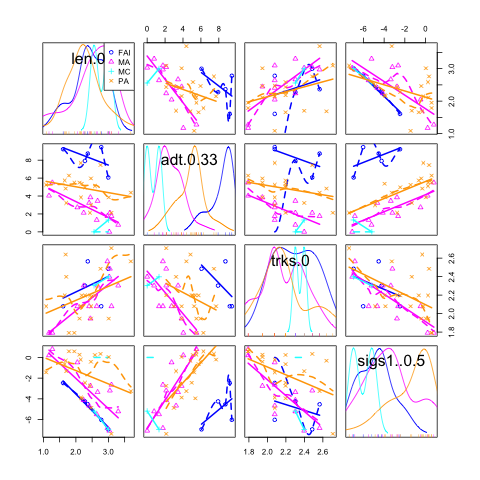

In [51]:
%%R

# test lambda = (0 0 0 -1)
print(testTransform(a3, c(0, 0, 0, -1)))

# save the rounded transformed values, plot them with a separate color for each highway type
transformedY <- bcPower(with(Highway1, cbind(len, adt, trks, sigs1)),
                        coef(a3, round=TRUE))
scatterplotMatrix( ~ transformedY|htype, Highway1)

## 5.3 Transforming Restricted-Range Variables

In regression models such as probit and logistic where the response variable is a probability, their range is restricted to the interval $[0,1]$, however, this can present problems for such models because values can cluster near the end points. Therefore, transformations that can spread the values such as the *arcsine square-root* are good choices for these cases. This transformation is known for its variance stabilizing properties and is given by:  

$$ T_{arcsinsqrt}(x) = \sin^{-1}\left(\sqrt{x}\right)$$

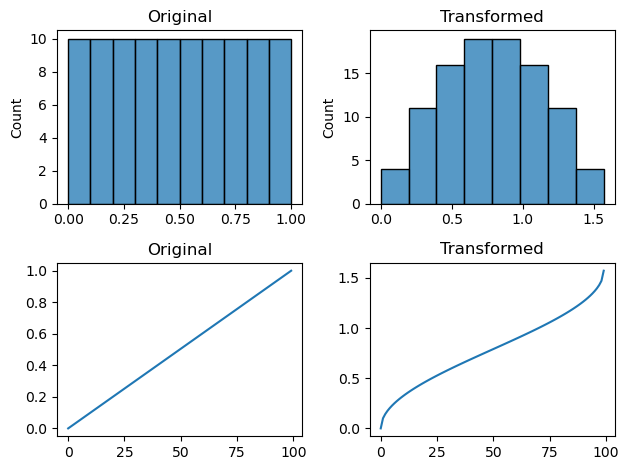

In [52]:
x = np.linspace(0, 1, 100)

# Plotting
fig8, ax8 = plt.subplots(2, 2)
sns.histplot(x, ax=ax8[0,0], bins=10)
ax8[0,0].set_title('Original')
sns.histplot(np.arcsin(np.sqrt(x)), ax=ax8[0,1])
ax8[0,1].set_title('Transformed')
ax8[1,0].plot(x)
ax8[1,0].set_title('Original')
ax8[1,1].plot(np.arcsin(np.sqrt(x)))
ax8[1,1].set_title('Transformed')
plt.tight_layout()

Another popular transformation choice is the *logit* transformation:
$$T_{logit}(x) = \rm{logit}(x) = \ln \left( \frac{x}{1-x}\right) $$

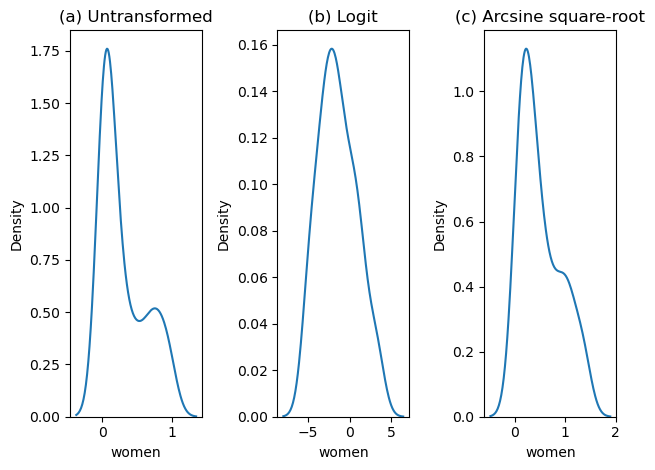

In [53]:
# Using 'prestige' data set

prest_women = prestige['women'] / 100 # originally percents

fig9, ax9 = plt.subplots(1, 3)
sns.kdeplot(prest_women, ax=ax9[0])
ax9[0].set_title('(a) Untransformed')
sns.kdeplot(np.log(prest_women / (1 - prest_women)), ax=ax9[1])
ax9[1].set_title('(b) Logit')
sns.kdeplot(np.arcsin(np.sqrt(prest_women)), ax=ax9[2])
ax9[2].set_title('(c) Arcsine square-root')
plt.tight_layout()

## 5.4 Transformations to Equalize Spread

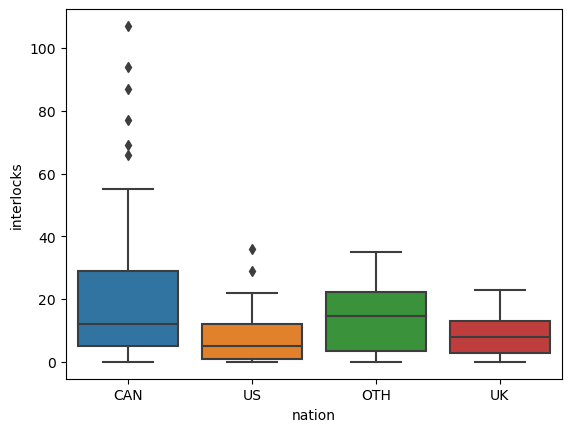

In [54]:
sns.boxplot(ornstein, x='nation', y='interlocks');

Consider again the Ornstein dataset showing the number of interlocks by country.

From the figure above, we can see that it would be helpful to even out the observed spread across countries. A measure of the spread-level can easily be obtain with Tukey's Spread-Level plot which also provides a suggested power-law transformation to stabilize the variance:  

    LowerHinge Median UpperHinge Hinge-Spread
US           2    6.0         13           11
UK           4    9.0         14           10
CAN          6   13.0         30           24
OTH          4   15.5         24           20

Suggested power transformation:  0.1534487 


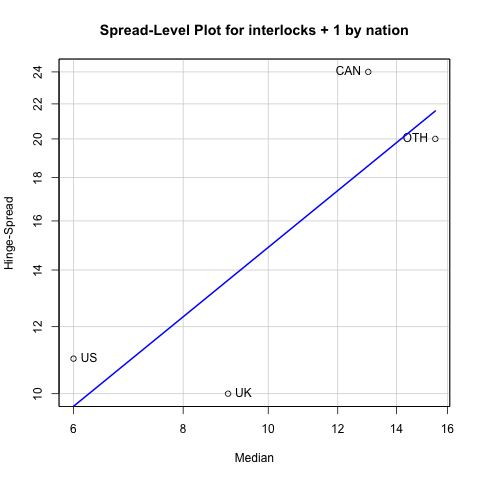

In [55]:
%%R
library(car)
library(carData)

data(Ornstein)
spreadLevelPlot(interlocks+1 ~ nation, Ornstein)

According to the output, the choice of $\lambda = 0.15$ would be an appropriate one. Since this value is close to 0, which would correspond to a log function, we can try a log to see if it works:

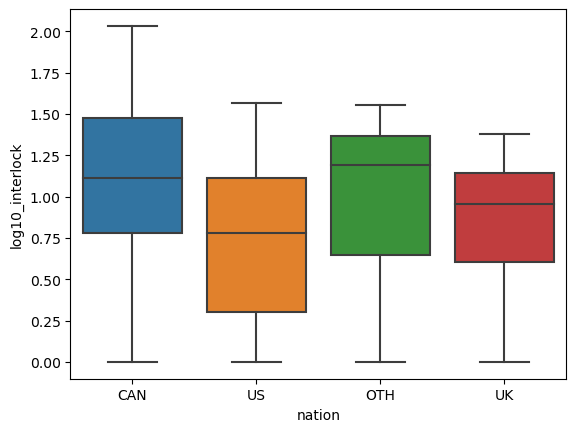

In [56]:
# Apply transformation
ornstein2 = ornstein.copy()
ornstein2['log10_interlock'] = np.log10(1 + ornstein['interlocks'])

# Plot
sns.boxplot(ornstein2, x='nation', y='log10_interlock');

## 5.5 Transformations Toward Linearity

We can consider transforming both $x$ and $y$ in an effort to linearize the relationship between them. For example, we can find the values of the positive exponents $p$ and $q$ such that the linear regression model ($Y_{i}^q = \beta_1 + \beta_2 X_{i}^{p} + e$) exhibits a more linear relationship. The choice of these exponents can be guided by Mosteller & Tukey's Bulging Rule for Linearization as shown in the figure below.

<img src="images/L1_fig7.png" alt="Mosteller & Tukey's Bulging Rule for Linearization" width="250">

For example, below is an adaptation of visualizations of this rule taken from https://freakonometrics.hypotheses.org/14967.

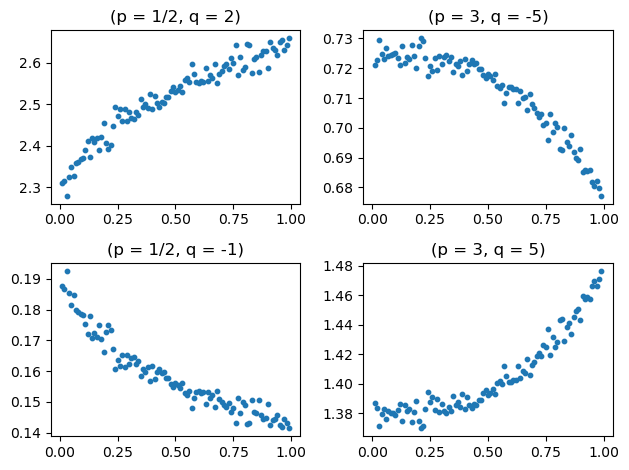

In [57]:
def fakedataMT(p=1, q=1, n=99, s=0.1):
    random.seed(10)
    X = np.linspace(1/(n + 1), 1 - 1/(n + 1), n) # x is set of points on (0, 1)
    Y = (5 + 2 * X**p + random.normal(size=n, scale=s))**(1/q) # generate y to follow (y^q = b1 + b2 x^p)
    return pd.DataFrame({'x':X, 'y':Y})

fig10, ax10 = plt.subplots(2, 2)
ax10[0,0].scatter(x=fakedataMT(p=1/2, q=2)['x'], y=fakedataMT(p=1/2, q=2)['y'], s=10)
ax10[0,0].set_title('(p = 1/2, q = 2)')
ax10[0,1].scatter(x=fakedataMT(p=3, q=-5)['x'], y=fakedataMT(p=3, q=-5)['y'], s=10)
ax10[0,1].set_title('(p = 3, q = -5)')
ax10[1,0].scatter(x=fakedataMT(p=1/2, q=-1)['x'], y=fakedataMT(p=1/2, q=-1)['y'], s=10)
ax10[1,0].set_title('(p = 1/2, q = -1)')
ax10[1,1].scatter(x=fakedataMT(p=3,q=5)['x'], y=fakedataMT(p=3, q=5)['y'], s=10)
ax10[1,1].set_title('(p = 3, q = 5)')
plt.tight_layout()

Take for example the bottom left graph; to describe that data, we can consider $$Y_i^{1/2}=\beta_1 + \beta_2 X^2_i + e_i$$ or more generally, $$Y_i^{1/a} = \beta_1 + \beta_2 X^b_i + e_i,$$ where $a,b > 1$. Larger values of $a$ and/or $b$ will result in higher convexity.

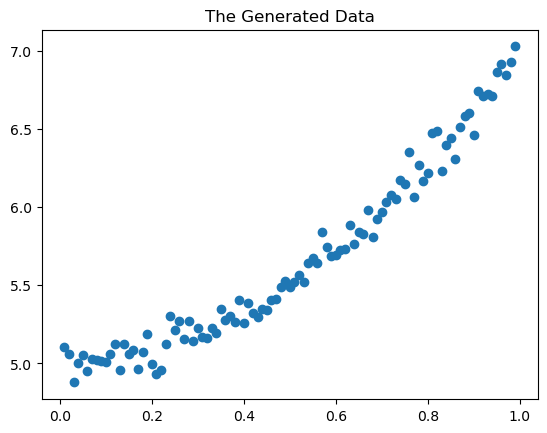

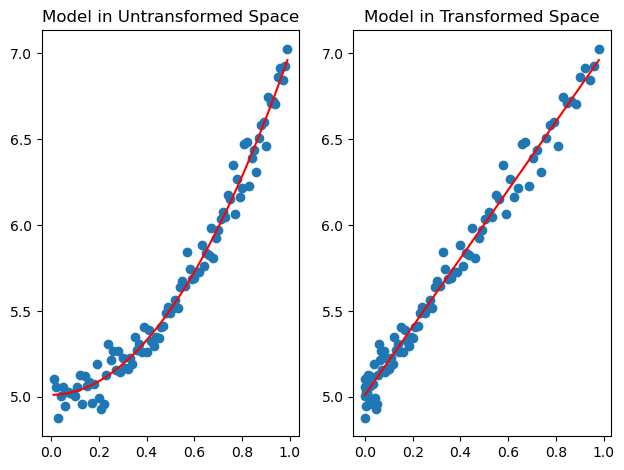

In [58]:
# Suppose p = 2 and q = 1 (y = b1 + b2 x^2)

# Generating data
mt_data = fakedataMT(p=2, q=1, s=0.08)
mt_data_span_x = np.linspace(mt_data['x'].min(), mt_data['x'].max(), 200)

plt.scatter(x=mt_data['x'], y=mt_data['y'])
plt.title('The Generated Data')
# Data looks to be in the bottom-right quadrant
# So would try p = 2, q = 1 (the true data)

# Model
mt_model = smf.ols('I(y**1) ~ I(x**2)', data=mt_data).fit()
mt_data_span_yhat = mt_model.predict(pd.DataFrame({'x':mt_data_span_x}))

# Transforming
mt_data_transf = pd.DataFrame({'x':mt_data['x']**2, 'y':mt_data['y']})
mt_data_span_x_transf = mt_data_span_x**2 # transformed x

# Plotting
fig11, ax11 = plt.subplots(1, 2)
ax11[0].scatter(x=mt_data['x'], y=mt_data['y'])
ax11[0].plot(mt_data_span_x, mt_data_span_yhat, color='r')
ax11[0].set_title('Model in Untransformed Space')
ax11[1].scatter(x=mt_data_transf['x'], y=mt_data['y'])
ax11[1].plot(mt_data_span_x_transf, mt_data_span_yhat, color='r')
ax11[1].set_title('Model in Transformed Space')
plt.tight_layout()

## 5.6 Section 5 Summary

When choosing a Functional form:

* We should do our best to choose a functional form that:
    + Consistent with economic theory
    + Fits the data well
    + Such that the assumptions of the regression model are satisfied
* In real-world problems it is sometimes difficult to achieve all these goals.
* In applications of econometrics we must simply do the best we can to choose a satisfactory functional form.

**Example:** Goodness-of-Fit and Modeling Issues

For this example we will estimate 4 models: (1) standard model, (2) log-linear, (3) linear-log, and (4) log-log and for each one we will:

1. Interpret the respective coefficient estimates, and $R^2$ 
2. Comment on the overall model fits
3. If appropriate, compare models
4. Provided a general discussion


### 5.6 (1) Standard Model

* slope: $\beta_2$
* elasticity: $\varepsilon = \beta_2 (\frac{x}{y})$
* Slope Interpretation: For a unit change in $x$ we expected a $\beta_2$ change in $y$.

In [59]:
# Model 1: Standard
## Using 'cps4_small' data set

cps4_ols = smf.ols('wage ~ educ', data=cps4_small).fit()
print(cps4_ols.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.175
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     211.7
Date:                Mon, 30 Sep 2024   Prob (F-statistic):           1.25e-43
Time:                        08:43:10   Log-Likelihood:                -3874.4
No. Observations:                1000   AIC:                             7753.
Df Residuals:                     998   BIC:                             7763.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -6.7103      1.914     -3.506      0.0

### 5.6 (2) Log-Linear

* slope: $\beta_2 y$ 
* elasticity: $\varepsilon = \beta_2 y$
* Slope Interpretation: $\frac{\Delta y}{y} \approx \beta_2 \Delta x$. A one unit change in $x$ is associated with a $100\times\beta_2\%$ change in $y$, or a $\Delta y\% = (100\beta_2)\Delta x$.

In [60]:
# Model 2: Log-Linear
## Using 'cps4_small' data set

cps4_LogLin = smf.ols('I(np.log(wage)) ~ educ', data=cps4_small).fit()
print(cps4_LogLin.summary())

                            OLS Regression Results                            
Dep. Variable:        I(np.log(wage))   R-squared:                       0.178
Model:                            OLS   Adj. R-squared:                  0.177
Method:                 Least Squares   F-statistic:                     216.4
Date:                Mon, 30 Sep 2024   Prob (F-statistic):           1.75e-44
Time:                        08:43:11   Log-Likelihood:                -776.65
No. Observations:                1000   AIC:                             1557.
Df Residuals:                     998   BIC:                             1567.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.6094      0.086     18.623      0.0

### 5.6 (3) Linear-Log

* slope: $\beta_2 (\frac{1}{x})$ 
* elasticity: $\varepsilon = \beta_2 (\frac{1}{y})$
* Slope Interpretation: $\Delta y \approx (\frac{\beta_2}{100}) (\Delta x \%)$. A 1\% change in $x$ is associated with a change in $y$ of $0.01\beta_2$.

In [61]:
# Model 3: Linear-Log
## Using 'food' data set

food_LinLog = smf.ols('food_exp ~ np.log(income)', data=food).fit()
print(food_LinLog.summary())

                            OLS Regression Results                            
Dep. Variable:               food_exp   R-squared:                       0.357
Model:                            OLS   Adj. R-squared:                  0.340
Method:                 Least Squares   F-statistic:                     21.05
Date:                Mon, 30 Sep 2024   Prob (F-statistic):           4.76e-05
Time:                        08:43:11   Log-Likelihood:                -236.41
No. Observations:                  40   AIC:                             476.8
Df Residuals:                      38   BIC:                             480.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept        -97.1864     84.237     -1.

### 5.6 (4) Log-Log

* slope: $\beta_2 (\frac{y}{x})$ 
* elasticity: $\varepsilon = \beta_2$
* Slope Interpretation: $\beta_2= \frac{\Delta y/y}{\Delta x/x} = \frac{\Delta y\%}{\Delta x\%} =$ elasticity of $y$ with respect to $x$.


In [62]:
# Model 4: Log-Log
## Using 'food' data set

food_LogLog = smf.ols('np.log(food_exp) ~ np.log(income)', data=food).fit()
print(food_LogLog.summary())

                            OLS Regression Results                            
Dep. Variable:       np.log(food_exp)   R-squared:                       0.445
Model:                            OLS   Adj. R-squared:                  0.431
Method:                 Least Squares   F-statistic:                     30.50
Date:                Mon, 30 Sep 2024   Prob (F-statistic):           2.57e-06
Time:                        08:43:11   Log-Likelihood:                -10.153
No. Observations:                  40   AIC:                             24.31
Df Residuals:                      38   BIC:                             27.68
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          3.9636      0.294     13.

# <font face="garamond" size="14" color="#122DAC">6. Regressions with Indicator Variables</font>

Factor variables  (also known as indicator or dummy variables) are used in regression to represent categorical variables, i.e., non-quantitative characteristics such as gender, race, drink preference, etc. The simplest example of a factor variable is a binary one, i.e., it can only take on two values (these are referred to as the *levels* of the factor). For example,
\begin{gather*}
UTOWN=\begin{cases}
1,\text{ if house is in University Town} \\
0,\text{ if house is in Golden Oaks}
\end{cases} \\
PRICE=\beta_{1}+\beta_{2}UTOWN+e
\end{gather*}

* When an indicator variable is used in a regression, it is important to write the regression function for the different values of the indicator variable. $$E[PRICE]=\begin{cases}\beta_1+\beta_2, \phantom{-}\text{ if }\phantom{.}UTOWN=1 \\ \beta_1,\phantom{---.} \text{ if } \phantom{.}UTOWN=0\end{cases}$$
* In the simple regression model, an indicator variable on the right-hand side gives us a way to estimate the differences between population means.
* It is straightforward to show that if $x$ is an indicator variable, we have
\begin{align*}
b_1 &= \bar{y}_0 \\ b_2 &= \bar{y}_1 - \bar{y}_0
\end{align*}

In case you learned about the test involving the difference of two means from some elementary statistics course before, you will realize that the regression here includes this earlier topic as a special case (i.e., using pooled variance).

Next we will go over a coded example. In this case we have binary indicator variable for gender, $I$, such that $I = 1$ (gender = female) and $I=0$ (gender = male). Our model is a regression of hourly wages (`WAGE`) on gender (`FEMALE` $=1$(female)). In this case our model can be expressed as:
$$
E(WAGE)=\beta_1+\beta_2 FEMALE =
\begin{cases}
\beta_1+\beta_2, \phantom{-}\text{ if }\phantom{.}FEMALE=1 \\
\beta_1,\phantom{---.} \text{ if } \phantom{.}FEMALE=0.
\end{cases}
$$

The respective the model parameters are given by $\beta_1=\overline{WAGE}_{Male}$ and $\beta_2=\overline{WAGE}_{Female} -\overline{WAGE}_{Male}$.

In [63]:
# Note: When dealing with indicator variables it is important to check the number of 
# observations in each category to see if the data are balanced or not.

# Import & data exploration
cps_small = pd.read_csv('data/cps_small.csv')
cps_small.describe()
# Are any indicator variables not well balanced?

wage         educ        exper       female        black  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean     10.213020    13.285000    18.780000     0.494000     0.088000   
std       6.246641     2.468171    11.318821     0.500214     0.283437   
min       2.030000     1.000000     0.000000     0.000000     0.000000   
25%       5.530000    12.000000    10.000000     0.000000     0.000000   
50%       8.790000    13.000000    18.000000     0.000000     0.000000   
75%      12.780000    16.000000    26.000000     1.000000     0.000000   
max      60.190000    18.000000    52.000000     1.000000     1.000000   

             white      midwest        south         west  
count  1000.000000  1000.000000  1000.000000  1000.000000  
mean      0.912000     0.237000     0.315000     0.222000  
std       0.283437     0.425455     0.464748     0.415799  
min       0.000000     0.000000     0.000000     0.000000  
25%       1.000000     0.000000     0.000000     0.000000  
50%       1.000000     0.000000     0.000000     0.000000  
75%       1.000000     0.000000     1.000000     0.000000  
max       1.000000     1.000000     1.000000     1.000000

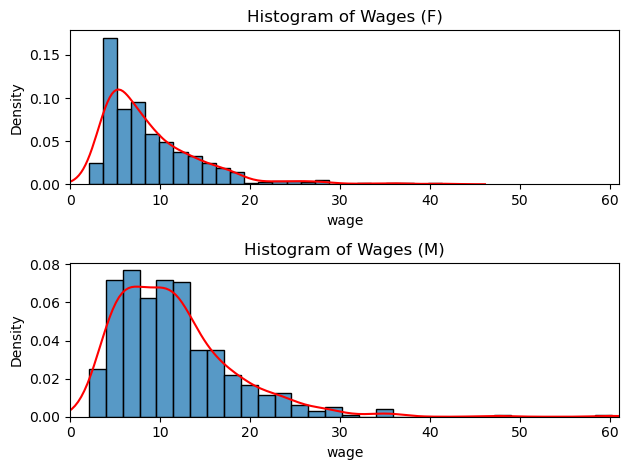

In [64]:
# First we will look at the distribution of wages conditioned on gender

# Partition
cps_f = cps_small['wage'][cps_small['female'] == 1]
cps_m = cps_small['wage'][cps_small['female'] == 0]

fig, ax = plt.subplots(2,1)
# Top plot will be F
sns.histplot(cps_f, stat='density', kde=False, ax=ax[0])
sns.kdeplot(cps_f, color='red', ax=ax[0])
ax[0].set_title('Histogram of Wages (F)')
ax[0].set_xlim((0,61))
# Bottom plot will be M
sns.histplot(cps_m, stat='density', kde=False, ax=ax[1])
sns.kdeplot(cps_m, color='red', ax=ax[1])
ax[1].set_title('Histogram of Wages (M)')
ax[1].set_xlim((0,61))
plt.tight_layout()

In [65]:
# Now we can estimate the model and interpret the results

cps_ols = smf.ols('wage ~ female', data=cps_small).fit() # fit model
print(cps_ols.summary())

# We interpret the y-intercept as the mean hourly wage for men (beta_1 = $11.53), and
# the slope as the difference in hourly wages between women and men (beta_1 = $-2.66). 
# On average, all else being equal, women are predicted to earn $2.66/hr less than men.

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.045
Model:                            OLS   Adj. R-squared:                  0.044
Method:                 Least Squares   F-statistic:                     47.31
Date:                Mon, 30 Sep 2024   Prob (F-statistic):           1.07e-11
Time:                        08:43:12   Log-Likelihood:                -3227.3
No. Observations:                1000   AIC:                             6459.
Df Residuals:                     998   BIC:                             6468.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.5255      0.271     42.455      0.0

# Ordinary Least Squares (Detailed Example -7 Steps)

## 1) Inspect the data

In [66]:
# Load Modules and Functions
import statsmodels.api as sm
import statsmodels as sms
import seaborn as sns
import statsmodels.formula.api as smf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import wooldridge as woo

# Load the data:
df = woo.dataWoo('wage1')

# Check the data object type
print(type(df))

# Look at the data 
print(df.head())

# Statistical summary of the data
print(df.describe())
# Q: Which indicator variables might be problematic? Why?

# Check the variables' types
print(df.info())

# Look for any missing observations
print(df.isnull().any())

# Extra sanity check, count the number of many missing obs per variable (if any)
print(df.isnull().sum())

<class 'pandas.core.frame.DataFrame'>
   wage  educ  exper  tenure  nonwhite  female  married  numdep  smsa  \
0  3.10    11      2       0         0       1        0       2     1   
1  3.24    12     22       2         0       1        1       3     1   
2  3.00    11      2       0         0       0        0       2     0   
3  6.00     8     44      28         0       0        1       0     1   
4  5.30    12      7       2         0       0        1       1     0   

   northcen  ...  trcommpu  trade  services  profserv  profocc  clerocc  \
0         0  ...         0      0         0         0        0        0   
1         0  ...         0      0         1         0        0        0   
2         0  ...         0      1         0         0        0        0   
3         0  ...         0      0         0         0        0        1   
4         0  ...         0      0         0         0        0        0   

   servocc     lwage  expersq  tenursq  
0        0  1.131402        4  

In [67]:
print(df.isnull().sum())

wage        0
educ        0
exper       0
tenure      0
nonwhite    0
female      0
married     0
numdep      0
smsa        0
northcen    0
south       0
west        0
construc    0
ndurman     0
trcommpu    0
trade       0
services    0
profserv    0
profocc     0
clerocc     0
servocc     0
lwage       0
expersq     0
tenursq     0
dtype: int64


In [68]:
print(df.isnull().any())

wage        False
educ        False
exper       False
tenure      False
nonwhite    False
female      False
married     False
numdep      False
smsa        False
northcen    False
south       False
west        False
construc    False
ndurman     False
trcommpu    False
trade       False
services    False
profserv    False
profocc     False
clerocc     False
servocc     False
lwage       False
expersq     False
tenursq     False
dtype: bool


In [69]:
df.isnull()

wage   educ  exper  tenure  nonwhite  female  married  numdep   smsa  \
0    False  False  False   False     False   False    False   False  False   
1    False  False  False   False     False   False    False   False  False   
2    False  False  False   False     False   False    False   False  False   
3    False  False  False   False     False   False    False   False  False   
4    False  False  False   False     False   False    False   False  False   
..     ...    ...    ...     ...       ...     ...      ...     ...    ...   
521  False  False  False   False     False   False    False   False  False   
522  False  False  False   False     False   False    False   False  False   
523  False  False  False   False     False   False    False   False  False   
524  False  False  False   False     False   False    False   False  False   
525  False  False  False   False     False   False    False   False  False   

     northcen  ...  trcommpu  trade  services  profserv  profocc  clerocc  \
0       False  ...     False  False     False     False    False    False   
1       False  ...     False  False     False     False    False    False   
2       False  ...     False  False     False     False    False    False   
3       False  ...     False  False     False     False    False    False   
4       False  ...     False  False     False     False    False    False   
..        ...  ...       ...    ...       ...       ...      ...      ...   
521     False  ...     False  False     False     False    False    False   
522     False  ...     False  False     False     False    False    False   
523     False  ...     False  False     False     False    False    False   
524     False  ...     False  False     False     False    False    False   
525     False  ...     False  False     False     False    False    False   

     servocc  lwage  expersq  tenursq  
0      False  False    False    False  
1      False  False    False    False  
2      False  False    False    False  
3      False  False    False    False  
4      False  False    False    False  
..       ...    ...      ...      ...  
521    False  False    False    False  
522    False  False    False    False  
523    False  False    False    False  
524    False  False    False    False  
525    False  False    False    False  

[526 rows x 24 columns]

## 2) Look at the distributions of the variables

/Users/randallr.rojas/anaconda3/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


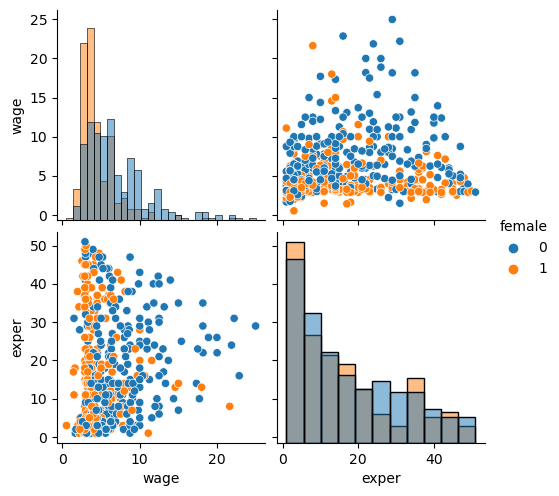

In [70]:
sns.pairplot(df,vars=['wage', 'exper'],hue="female", diag_kind="hist")
# For the PDF, just leave out diag_kind"

## 3) Fit the OLS Model

In [71]:
# Specify the Model
ols_mod = smf.ols(formula='wage ~ exper', data=df)

# Fit the Model
ols_fit = ols_mod.fit()
# Type: dir(ols_fit) to look at other accessible attributes

# Look at the Model Fit Summary
print(ols_fit.summary())

                            OLS Regression Results                            
Dep. Variable:                   wage   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.011
Method:                 Least Squares   F-statistic:                     6.766
Date:                Mon, 30 Sep 2024   Prob (F-statistic):            0.00955
Time:                        09:03:24   Log-Likelihood:                -1429.7
No. Observations:                 526   AIC:                             2863.
Df Residuals:                     524   BIC:                             2872.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      5.3733      0.257     20.908      0.0

## 4) Evaluate the Model

In [72]:
import statsmodels.stats.api as sms
from simple_colors import *
# Linearity: Harvey-Collier --> Ho: model is linear
name = ["t-stat", "p-value"]
test = sms.linear_harvey_collier(ols_fit)
print(blue("Linearity Test Results:",['bold']))
print(list(zip(name, test)))
print("\n")

# Normaility of the Residuals: Jarque-Bera --> Residuals ~ N(0,1)
name = ["Jarque-Bera", "Chi^2 two-tail prob.", "Skew", "Kurtosis"]
test = sms.jarque_bera(ols_fit.resid)
print(blue("JB Results:",['bold']))
print(list(zip(name, test)))
print("\n")

# Heteroskedasticity: Breush-Pagan --> Ho: var = constant
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(ols_fit.resid, ols_fit.model.exog)
print(blue("BP Results:",['bold']))
print(list(zip(name, test)))

Linearity Test Results:
[('t-stat', -3.252506285513865), ('p-value', 0.0012178806000890992)]


JB Results:
[('Jarque-Bera', 851.5424757340141), ('Chi^2 two-tail prob.', 1.2299879060931128e-185), ('Skew', 1.962381539797588), ('Kurtosis', 7.842508012586803)]


BP Results:
[('Lagrange multiplier statistic', 5.736479683841363), ('p-value', 0.016616063038613998), ('f-value', 5.7776784974395685), ('f p-value', 0.016577290872716074)]


## 5) Look at the diagnostic plots

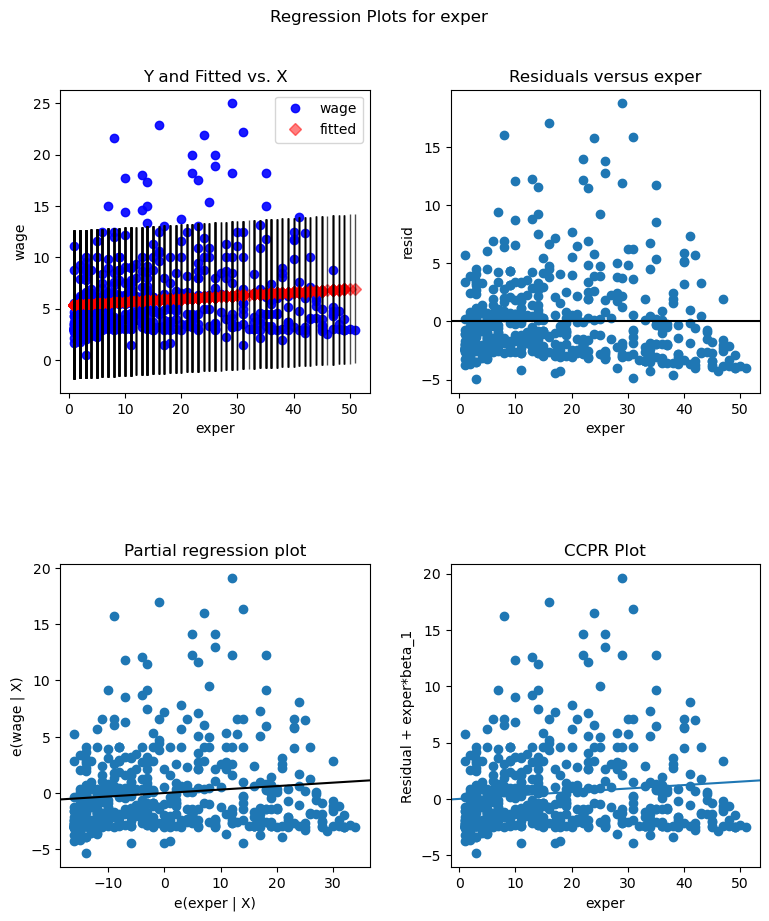

In [73]:
figD = sm.graphics.plot_regress_exog(ols_fit, "exper")
figD.set_figheight(10)
figD.set_figwidth(8)
plt.show()

[Text(0.5, 0, 'Predicted'), Text(0, 0.5, 'Residuals')]

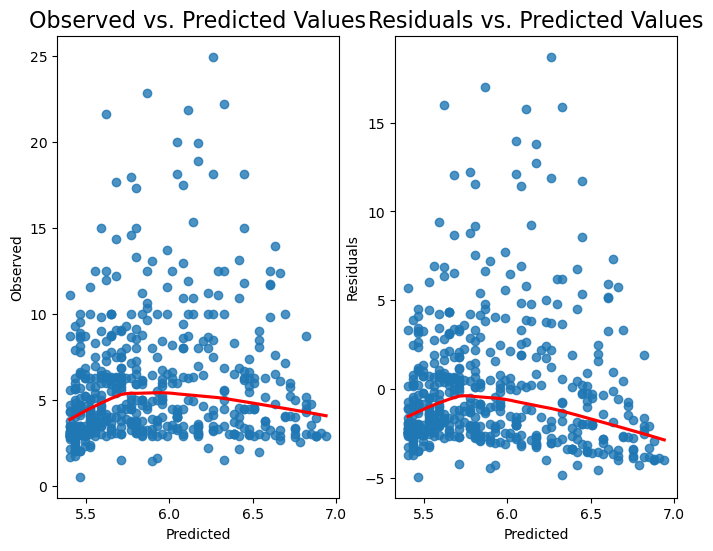

In [74]:
import seaborn as sns 

fig, ax = plt.subplots(1,2,figsize=(8, 6))
sns.regplot(x=ols_fit.fittedvalues, y=df['wage'], lowess=True, ax=ax[0], line_kws={'color': 'red'})
ax[0].set_title('Observed vs. Predicted Values', fontsize=16)
ax[0].set(xlabel='Predicted', ylabel='Observed')

sns.regplot(x=ols_fit.fittedvalues, y=ols_fit.resid, lowess=True, ax=ax[1], line_kws={'color': 'red'})
ax[1].set_title('Residuals vs. Predicted Values', fontsize=16)
ax[1].set(xlabel='Predicted', ylabel='Residuals')

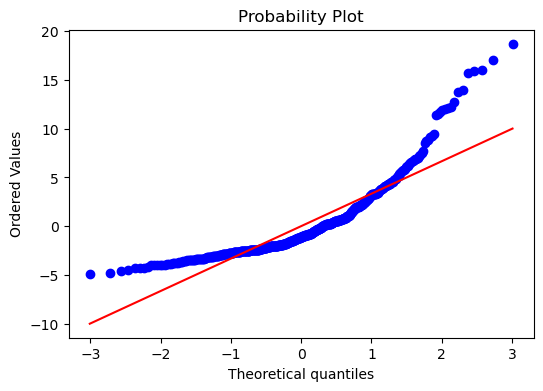

In [75]:
# QQ Plot (Normal Probability) 
import scipy as sp
figA, axA = plt.subplots(figsize=(6,4))
_, (__, ___, r) = sp.stats.probplot(ols_fit.resid, plot = axA, fit=True)

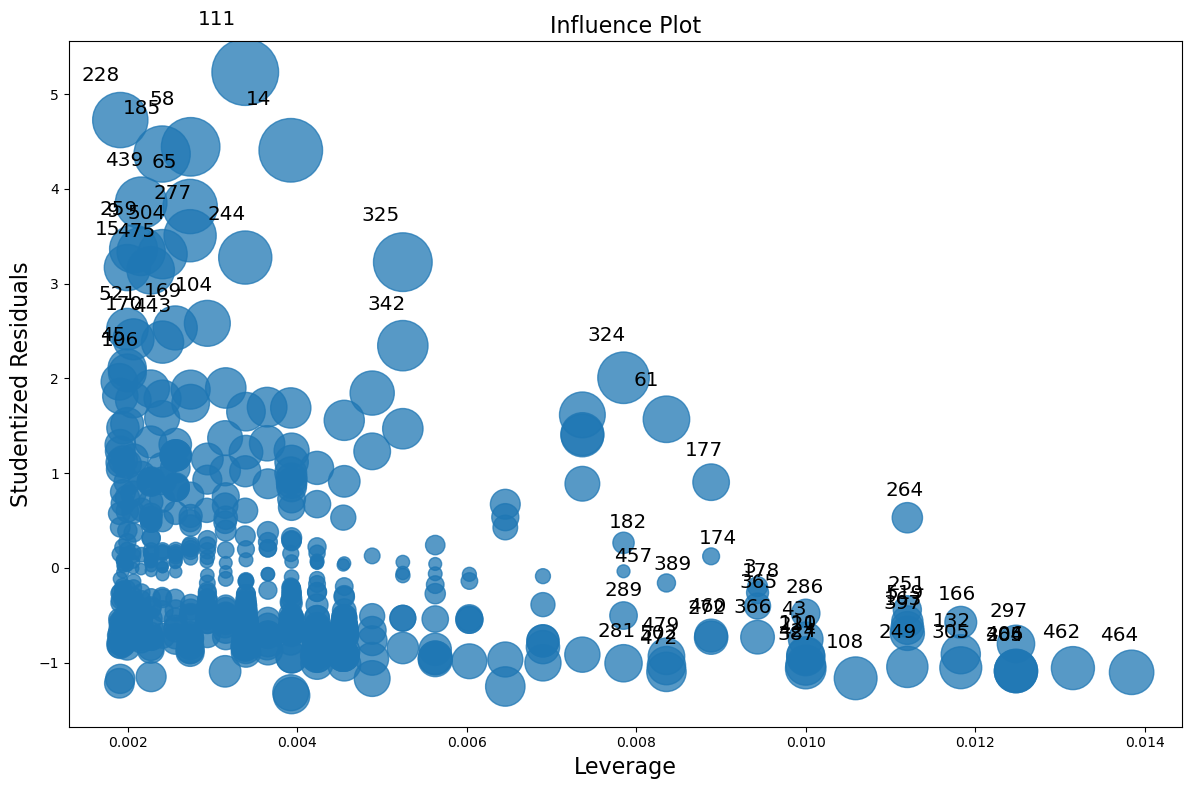

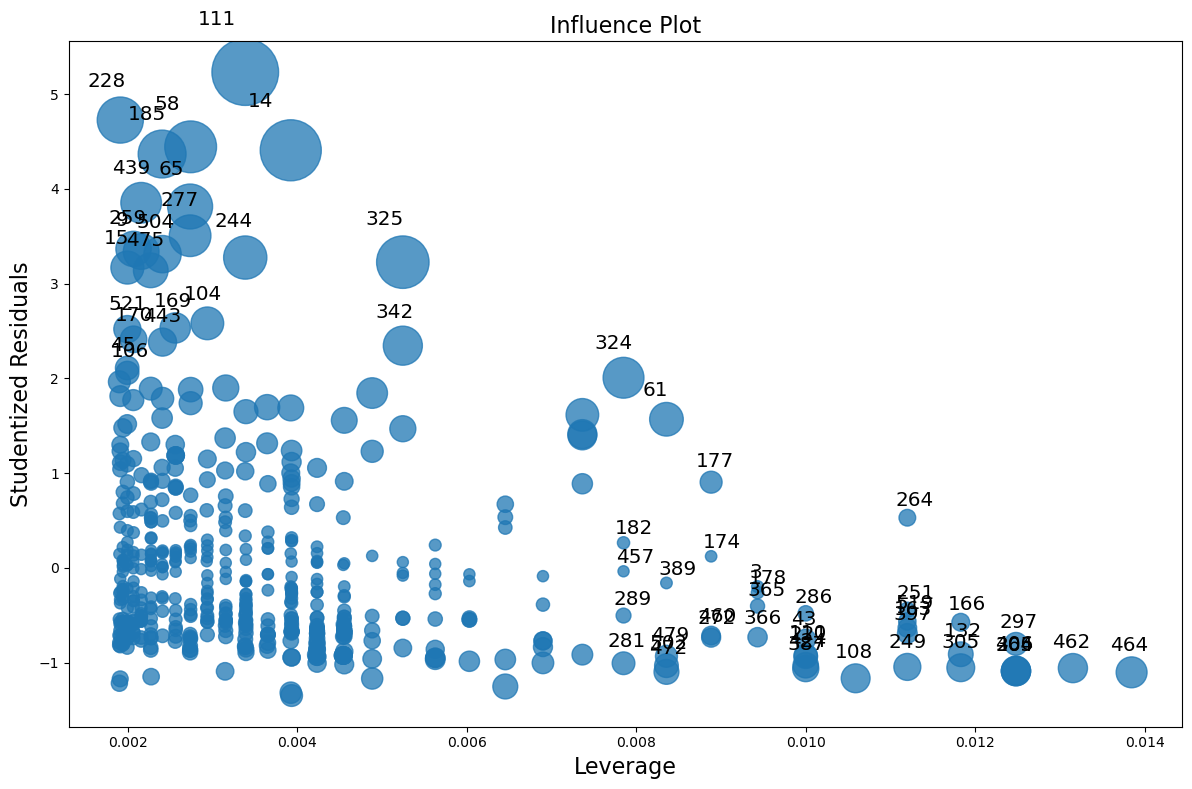

In [76]:
# Outliers, high leverage, influential obs
figd, ax = plt.subplots(figsize=(12,8))
figd = sm.graphics.influence_plot(ols_fit, ax = ax, criterion="DFFITS")
figd.tight_layout(pad=1.0)

fige, ax = plt.subplots(figsize=(12,8))
fige = sm.graphics.influence_plot(ols_fit, ax = ax, criterion="cooks")
fige.tight_layout(pad=1.0)

# R Version (Plot) of the Residuals Analysis

The code below sets the environment for R syntax so that we can directly use the R libbraries and respective funcntions of interest.

In [77]:
# Install these in R
# pip install rpy2

#library to use R in Python 
import rpy2

import warnings
warnings.filterwarnings('ignore')

from rpy2.robjects import pandas2ri
import rpy2.rinterface as rinterface
pandas2ri.activate()

%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


--- Please select a CRAN mirror for use in this session ---



Attaching package: ‘wooldridge’

The following object is masked from ‘package:MASS’:

    cement

Learn more about olsrr at https://github.com/rsquaredacademy/olsrr/.

Attaching package: ‘olsrr’

The following object is masked from ‘package:wooldridge’:

    cement

The following object is masked from ‘package:MASS’:

    cement

The following object is masked from ‘package:datasets’:

    rivers



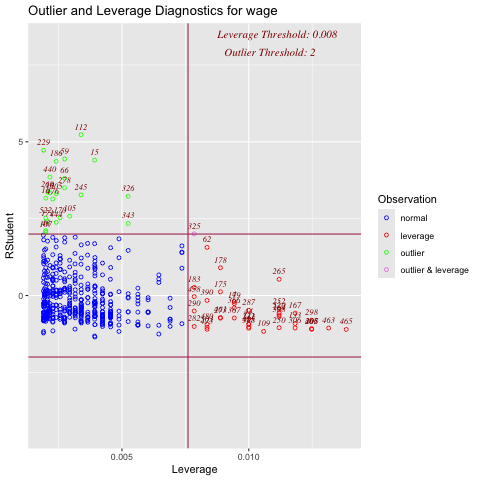

In [78]:
%%R 
# Look  at the data
library(wooldridge)
library(olsrr)
mreg.mod= lm(wage ~ exper,data = wage1)
ols_plot_resid_lev(mreg.mod)

-0.21012361941183624


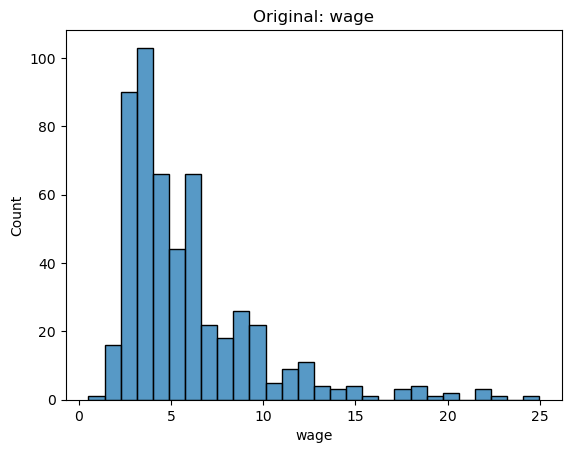

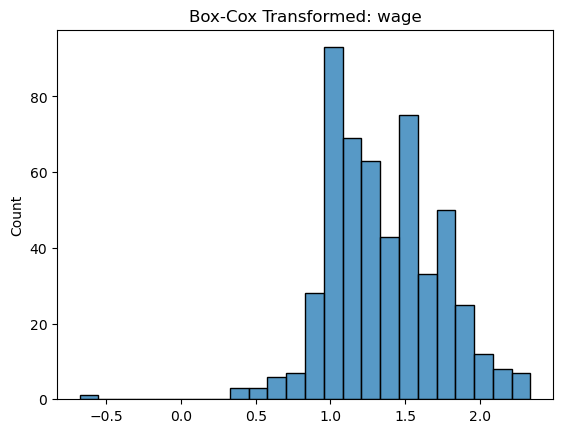

0.30455181084484656


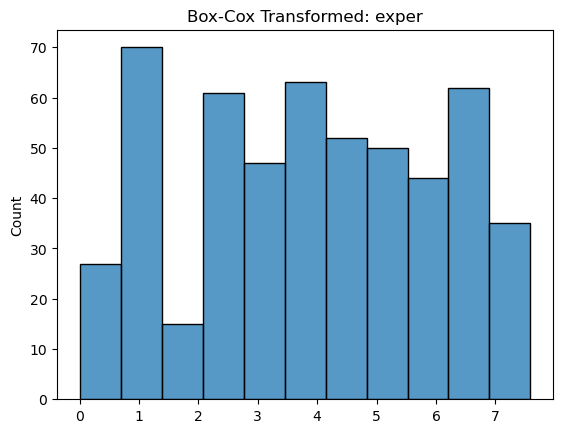

In [79]:
# Box-Cox Transformations
import scipy
bc_wage,lambda_wage = scipy.stats.boxcox(df["wage"])
print(lambda_wage)

sns.histplot(df["wage"])
plt.title("Original: wage")
plt.show()

sns.histplot(bc_wage)
plt.title("Box-Cox Transformed: wage")
plt.show()

bc_exper,lambda_exper = scipy.stats.boxcox(df["exper"])
print(lambda_exper)

sns.histplot(bc_exper)
plt.title("Box-Cox Transformed: exper")
plt.show()

## 6) Examine the Bootstrap estimates

The script below is an adaptation from [towards data science](https://towardsdatascience.com/linear-regression-with-bootstrapping-4924c05d2a9).

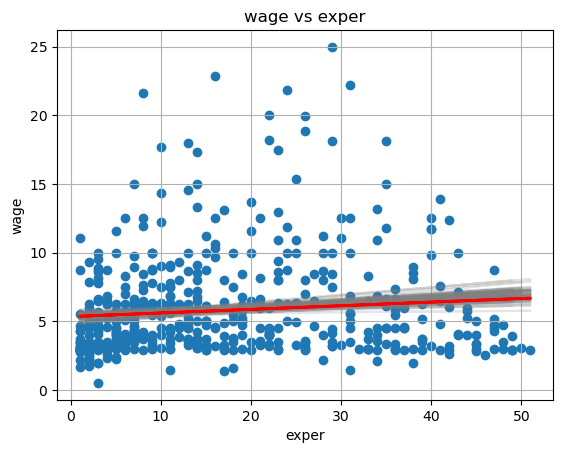

In [80]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.formula.api as sm
import wooldridge as woo

# Load the data:
df = woo.dataWoo('wage1')

# resample with replacement each row
boot_slopes = []
boot_interc = []
boot_adjR2 = []
n_boots = 100
n_points = df.shape[0]
plt.figure()
for _ in range(n_boots):
 # sample the rows, same size, with replacement
    sample_df = df.sample(n=n_points, replace=True)
 # fit a linear regression
    ols_model_temp = sm.ols(formula = 'wage ~ exper', data=sample_df)
    results_temp = ols_model_temp.fit()
 
 # append coefficients
    boot_interc.append(results_temp.params[0])
    boot_slopes.append(results_temp.params[1])
    boot_adjR2.append(results_temp.rsquared_adj)
 
 # plot a greyed out line
    y_pred_temp = ols_model_temp.fit().predict(sample_df['exper'])
    plt.plot(sample_df['exper'], y_pred_temp, color='grey', alpha=0.2)
# add data points
y_pred = ols_model_temp.fit().predict(df['exper'])
plt.scatter(df['exper'], df['wage'])
plt.plot(df['exper'], y_pred, linewidth=2,color = 'red')
plt.grid(True)
plt.xlabel('exper')
plt.ylabel('wage')
plt.title('wage vs exper')
plt.show()

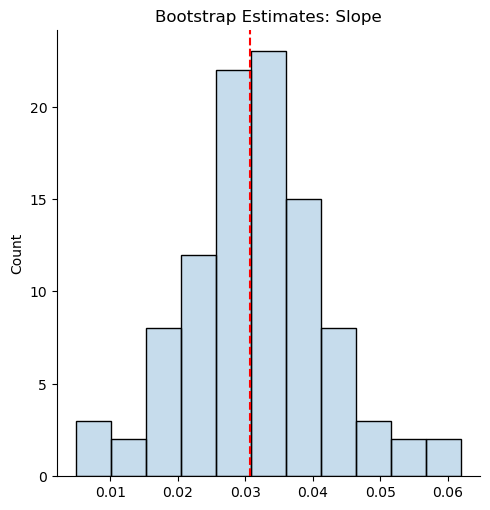

In [81]:
import seaborn as sns
sns.displot(boot_slopes, alpha = 0.25)
plt.axvline(x=0.0307,color='red', linestyle='--')
plt.title('Bootstrap Estimates: Slope')
plt.show()

# The vertical red line = LS estimate

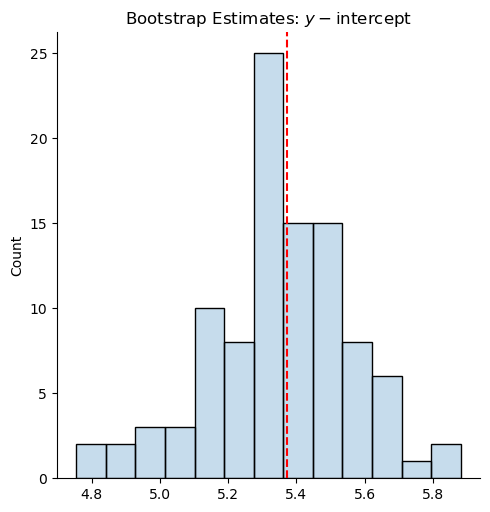

In [82]:
sns.displot(boot_interc, alpha = 0.25)
plt.axvline(x=5.3733,color='red', linestyle='--')
plt.title('Bootstrap Estimates: $y-$intercept')
plt.show()
# The vertical red line = LS estimate

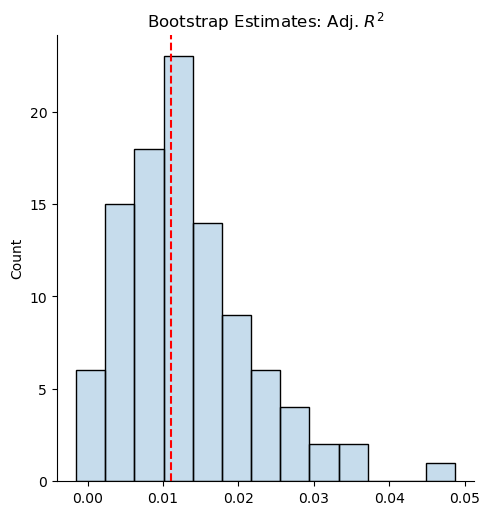

In [83]:
sns.displot(boot_adjR2, alpha = 0.25)
plt.axvline(x=0.011,color='red', linestyle='--')
plt.title('Bootstrap Estimates: Adj. $R^2$')
plt.show()

# The vertical red line = LS estimate

## Note: Clluen-Frey Graph

You will need to install the `fitter` package first (`pip install fitter`), and although the output is not identical to the one from the lecture notes, this package works quite well. Keep in mind that it may take a couple of minutes to run.

SKIPPED _fit distribution (taking more than 30 seconds)
SKIPPED kstwo distribution (taking more than 30 seconds)
SKIPPED rv_continuous distribution (taking more than 30 seconds)
SKIPPED rv_histogram distribution (taking more than 30 seconds)
SKIPPED vonmises_fisher distribution (taking more than 30 seconds)
SKIPPED studentized_range distribution (taking more than 30 seconds)


sumsquare_error         aic         bic  kl_div  ks_statistic  \
beta               0.547634  622.545754  632.966435     inf      0.071250   
exponpow           0.547894  640.403694  648.219205     inf      0.049661   
exponweib          0.548653  628.472709  638.893390     inf      0.050590   
gausshyper         0.551538  625.222236  640.853258     inf      0.084175   
chi                0.553051  637.046200  644.861710     inf      0.055658   

            ks_pvalue  
beta         0.663590  
exponpow     0.955733  
exponweib    0.948634  
gausshyper   0.453371  
chi          0.898876

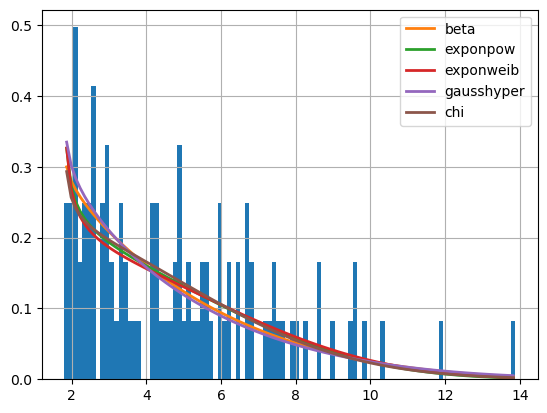

In [84]:
# Generate some data:
from scipy import stats
data = stats.gamma.rvs(2, loc=1.5, scale=2, size=100)

# Fit various distributions:
from fitter import Fitter
f = Fitter(data)
f.fit()
# may take some time since by default, all distributions are tried
# but you call manually provide a smaller set of distributions
f.summary()

## 7) Evaluate the model performance using Cross-Validation

We will use the [Scikit-Learn](https://scikit-learn.org/stable/) package.

In [85]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.model_selection import cross_val_score

x = df[['exper']]
y = df[['wage']]
# Perform an OLS fit using all the data
regr = LinearRegression()
model = regr.fit(x,y)
regr.coef_
regr.intercept_

# Split the data into train  (70%)/test(30%) samples:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

# Train the model:
regr = LinearRegression()
regr.fit(x_train, y_train)

# Make predictions based on the test sample
y_pred = regr.predict(x_test)

# Evaluate Performance

print('MAE:', metrics.mean_absolute_error(y_test, y_pred))
print('MSE:', metrics.mean_squared_error(y_test, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

# Perform a 5-fold CV
# Use MSE as the scoring function (there are other options as shown here:
# https://scikit-learn.org/stable/modules/model_evaluation.html

regr = linear_model.LinearRegression()
scores = cross_val_score(regr, x, y, cv=5, scoring='neg_root_mean_squared_error')
print('5-Fold CV RMSE Scores:', scores)

MAE: 2.6699623984766934
MSE: 12.059234726999012
RMSE: 3.4726408865586738
5-Fold CV RMSE Scores: [-4.3982781  -3.8027313  -3.5078229  -2.95388475 -3.7262548 ]
